# 目錄
## ．放入融資融券
### ．．．測試預測幾天後的成效最好（看起來是8天）
### ．．．建立 rolling models
## ．畫Y999股價搭配牛熊顏色的圖
## ．加入其他基本因子
## ．加入新聞輿情與熱度
### ．．．正規化全部因子
## ．加入更多因子
## ．使用不同演算法：logistic regression, naive bayes, SVM
### ．．．logistic regression 進行 feature selections
## ．進行RF feature selections （使用SelectFromModel, RFECV）

In [3]:
import matplotlib
# sans-serif
matplotlib.rcParams

RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': False,
          'axes.grid.axis': 'both',
          'axes.grid.which':

# Read in label dataframe

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

In [2]:
label = pd.read_csv('algoDefLabel.csv')
label['bb'] = label['algoDefine'].apply(lambda x: int(x))

In [3]:
margin = pd.read_csv('./index_data/margin_20050103_20220511.csv', encoding='big5')

In [4]:
filtered_margin = margin[['年月日', '融資餘額(張)', '融資餘額(千元)', '融券餘額(張)', '融券餘額(千元)', '借券賣出餘額(張)', '借券賣出餘額(千元)', '借券賣出可使用額度', '借券賣出限額', '券資比']]

In [5]:
# for i in margin.columns:
#     print(i, end='  ')

公司代碼  簡稱  年月日  

#### 融資餘額(張)  融資餘額(千元)  
    融資買進(張)  融資買進(千元)  
    融資賣出(張)  融資賣出(千元)  
    融資現金償還(張)  融資現金償還(千元)  
    融資增減(張)  融資增減(千元)  融資增減比率  
    融資使用率  融資限額  

#### 融券餘額(張)  融券餘額(千元)  
    融券買進(張)  融券買進(千元)  
    融券賣出(張)  融券賣出(千元)  
    融券現券償還(張)  融券現券償還(千元)  
    融券增減(張)  融券增減(千元)  融券增減比率  
    融券使用率  融券限額  

是否可信用交易(Y)  #### 券資比  資券互抵  當日收盤  

融資(買+賣)/成交量 %  融券(買+賣)/成交量 %  

#### 借券賣出餘額(張)  借券賣出餘額(千元)  
    借券賣出(張)  借券賣出(千元)  
    借券賣出庫存異動(張)  借券賣出庫存異動(千元)  
    #### 借券賣出可使用額度  借券賣出限額  
    借券賣出(千元)_交易所  融券賣出(千元)_交易所  

均價  
每股融資成本  每股融券成本  
融資維持率  融券維持率  整戶維持率  

#### CPI總指數

In [6]:
df = filtered_margin.merge(label[['Date', 'close_adj', 'bb']], left_on='年月日', right_on='Date')

In [7]:
df

,年月日,融資餘額(張),融資餘額(千元),融券餘額(張),融券餘額(千元),借券賣出餘額(張),借券賣出餘額(千元),借券賣出可使用額度,借券賣出限額,券資比,Date,close_adj,bb
0,2008/01/02,17416413,330226419.0,446743,22386158.26,941766,40182569.36,15829848,52766131,2.57,2008/01/02,9845.42,0
1,2008/01/03,17457081,332032980.0,431996,20588767.58,943067,38679629.96,15820023,52733376,2.47,2008/01/03,9681.17,0
2,2008/01/04,17515892,334346118.0,448848,20666002.95,933568,38116807.14,15815849,52719469,2.56,2008/01/04,9724.82,0
3,2008/01/07,17446380,333416251.0,430747,19149243.61,938141,36351105.52,15816449,52721469,2.47,2008/01/07,9325.32,0
4,2008/01/08,17459758,333013941.0,451952,19760438.32,948282,36230978.44,16106439,53688104,2.59,2008/01/08,9419.41,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3530,2022/05/04,8483629,252497763.0,388583,22595578.84,10974527,531024203.68,1341851,76197874,4.58,2022/05/04,32947.47,0
3531,2022/05/05,8518787,253143450.0,398061,23445108.11,10906950,535959494.53,1337917,76205474,4.67,2022/05/05,33206.59,0
3532,2022/05/06,8506707,253016723.0,390208,22495883.07,10824940,523467852.96,1338743,76234516,4.59,2022/05/06,32633.97,0
3533,2022/05/09,8390725,250125870.0,392470,21799703.83,10948167,519945004.74,1338754,76251750,4.68,2022/05/09,31919.41,0


# Start Training

In [8]:
df[df['年月日'] < '2021/01/01']

,年月日,融資餘額(張),融資餘額(千元),融券餘額(張),融券餘額(千元),借券賣出餘額(張),借券賣出餘額(千元),借券賣出可使用額度,借券賣出限額,券資比,Date,close_adj,bb
0,2008/01/02,17416413,330226419.0,446743,22386158.26,941766,40182569.36,15829848,52766131,2.57,2008/01/02,9845.42,0
1,2008/01/03,17457081,332032980.0,431996,20588767.58,943067,38679629.96,15820023,52733376,2.47,2008/01/03,9681.17,0
2,2008/01/04,17515892,334346118.0,448848,20666002.95,933568,38116807.14,15815849,52719469,2.56,2008/01/04,9724.82,0
3,2008/01/07,17446380,333416251.0,430747,19149243.61,938141,36351105.52,15816449,52721469,2.47,2008/01/07,9325.32,0
4,2008/01/08,17459758,333013941.0,451952,19760438.32,948282,36230978.44,16106439,53688104,2.59,2008/01/08,9419.41,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3205,2020/12/25,8745028,184261341.0,1163281,27977389.83,8162513,329407523.66,1792119,72503262,13.30,2020/12/25,27667.00,1
3206,2020/12/28,8868468,186790038.0,1197623,29302775.94,8221767,333830873.72,1810826,72498309,13.50,2020/12/28,27959.77,1
3207,2020/12/29,8777489,185949806.0,1185802,28971069.69,8234700,334385107.12,1836023,72502998,13.51,2020/12/29,27938.50,1
3208,2020/12/30,8842775,187131498.0,1176219,29232796.17,8249918,335615679.12,1854665,72501128,13.30,2020/12/30,28354.81,1


# Add other basic factors

EA1101: 2

EB0308: 14

EB0311: 17

EB0312: 18

EB18: 26

EB23: 31

EC03: 35

EC08: 38

LA07 LA0702: 41 42

#### MA1601: 43

#### PA0110 PA0118: 52 54

In [9]:
df_2 = copy.copy(df)
df_2['年月'] = df['年月日'].apply(lambda x: x[:7])
print(df_2)

files = os.listdir('/Users/arthur/Desktop/bbmarket/index_data/data/')
files = sorted(files)

for i in range(len(files)):
    if i in [2, 14, 17, 18, 26, 31, 35, 38, 41, 42, 43, 52, 54]:
        factor_df = pd.read_excel('/Users/arthur/Desktop/bbmarket/index_data/data/'+files[i])
        
        name = factor_df.columns[0][:-21]
        factor_df.columns =  [factor_df.iloc[1, 0], name, factor_df.iloc[1, 2]]
        factor_df = factor_df.iloc[2:, :].reset_index(drop=True)
        factor_df.columns.name=''
        
        df_2 = df_2.merge(factor_df[['年月', name]], left_on='年月', right_on='年月')
print(df_2)

             年月日   融資餘額(張)     融資餘額(千元)  融券餘額(張)     融券餘額(千元)      借券賣出餘額(張)  \
0     2008/01/02  17416413  330226419.0   446743  22386158.26         941766   
1     2008/01/03  17457081  332032980.0   431996  20588767.58         943067   
2     2008/01/04  17515892  334346118.0   448848  20666002.95         933568   
3     2008/01/07  17446380  333416251.0   430747  19149243.61         938141   
4     2008/01/08  17459758  333013941.0   451952  19760438.32         948282   
...          ...       ...          ...      ...          ...            ...   
3530  2022/05/04   8483629  252497763.0   388583  22595578.84       10974527   
3531  2022/05/05   8518787  253143450.0   398061  23445108.11       10906950   
3532  2022/05/06   8506707  253016723.0   390208  22495883.07       10824940   
3533  2022/05/09   8390725  250125870.0   392470  21799703.83       10948167   
3534  2022/05/10   8303845  248696514.0   378888  20708153.69       10969392   

           借券賣出餘額(千元)      借券賣出可使用額度   

# 市場輿情分數與熱度

In [12]:
SEN = pd.read_csv('./index_data/sentimentIndex.csv')
SEN.columns = ['年月日'] + list(SEN.columns[1:])
SEN['年月日'] = ['/'.join(i.split('-')) for i in SEN['年月日']]
SEN['Trend'] = SEN.iloc[:, 1:].apply(np.nanmean, axis=1)

HEAT = pd.read_csv('./index_data/heatIndex.csv')
HEAT.columns = ['年月日'] + list(HEAT.columns[1:])
HEAT['年月日'] = ['/'.join(i.split('-')) for i in HEAT['年月日']]
HEAT['Heat'] = HEAT.iloc[:, 1:].apply(np.nanmean, axis=1)

SEN2 = pd.read_csv('./index_data/trendIndex.csv')
SEN2.columns = ['年月日'] + list(SEN2.columns[1:])
SEN2['年月日'] = ['/'.join(i.split('-')) for i in SEN2['年月日']]
SEN2['Trend2'] = SEN2.iloc[:, 1:].apply(np.nanmean, axis=1)

HEAT2 = pd.read_csv('./index_data/heatIndex2.csv')
HEAT2.columns = ['年月日'] + list(HEAT2.columns[1:])
HEAT2['年月日'] = ['/'.join(i.split('-')) for i in HEAT2['年月日']]
HEAT2['Heat2'] = HEAT2.iloc[:, 1:].apply(np.nanmean, axis=1)

In [13]:
df_3 = df_2.merge(SEN[['年月日', 'Trend']], on='年月日')
df_3 = df_3.merge(HEAT[['年月日', 'Heat']], on='年月日')
df_3 = df_3.merge(SEN2[['年月日', 'Trend2']], on='年月日')
df_3 = df_3.merge(HEAT2[['年月日', 'Heat2']], on='年月日')
# df_3 = df_3.merge(margin[margin.columns[2:]], on='年月日')
df_3

,年月日,融資餘額(張),融資餘額(千元),融券餘額(張),融券餘額(千元),借券賣出餘額(張),借券賣出餘額(千元),借券賣出可使用額度,借券賣出限額,券資比,...,EC08 台灣股價指數變動率-月均值(百分比),LA07 台灣-失業率-月(百分比),LA0702 台灣-失業率(經季節調整)-月(百分比),MA1601 台灣-貨幣總計數-M2年增率-期底-月(百分比),PA0110 台灣-CPI總指數(2016=100)-月(指數),PA0118 台灣-CPI-總指數(經季節調整)(2016=100)-月(指數),Trend,Heat,Trend2,Heat2
0,2013/01/02,11202904,180297414.0,869131,37362993.48,4317824,162806822.23,464277,63214239,7.76,...,8.12,4.16,4.2,2.9,97.45,98.48,3.260929,1.000000,0.500000,1.304194
1,2013/01/03,11207000,180690515.0,886405,38371415.22,4265426,163280661.07,475138,63212096,7.91,...,8.12,4.16,4.2,2.9,97.45,98.48,4.971712,0.919214,0.322917,1.217502
2,2013/01/04,11248020,181996929.0,899789,37927615.24,4284513,162851472.10,485618,63213887,8.00,...,8.12,4.16,4.2,2.9,97.45,98.48,4.858022,0.754579,0.546053,1.189524
3,2013/01/07,11297769,183197039.0,888119,36870039.79,4289948,162084860.46,486600,63212395,7.86,...,8.12,4.16,4.2,2.9,97.45,98.48,5.192612,0.549632,0.226415,1.026759
4,2013/01/08,11318550,184412388.0,876746,35271737.14,4285353,160316606.10,486578,63214543,7.75,...,8.12,4.16,4.2,2.9,97.45,98.48,3.953038,0.575573,0.141104,1.012500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2201,2021/12/24,9427245,281583023.0,527298,34149543.16,9697178,520524033.78,1620810,75032644,5.59,...,24.99,3.64,3.7,7.35,105.41,105.95,7.755893,0.202140,0.217687,0.346139
2202,2021/12/27,9452563,282330905.0,527225,33951938.58,9701874,523012279.67,1594671,75023583,5.58,...,24.99,3.64,3.7,7.35,105.41,105.95,8.319634,0.171378,0.476744,0.309086
2203,2021/12/28,9423456,281689753.0,524513,33733375.57,9685959,524227132.23,1567413,75018921,5.57,...,24.99,3.64,3.7,7.35,105.41,105.95,8.252676,0.205510,0.580645,0.327092
2204,2021/12/29,9418022,281976763.0,532419,34097204.71,9631146,520922268.85,1540210,75224171,5.65,...,24.99,3.64,3.7,7.35,105.41,105.95,7.793915,0.194017,0.486842,0.329154


#### 更多因子：Y999股票、不同因子溢酬
#### 不同演算法

## Y999股票trend

In [15]:
df_3['price_trend'] = df_3['close_adj'].rolling(30).apply(lambda x: x.iloc[-1]-np.nanmean(x))

/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


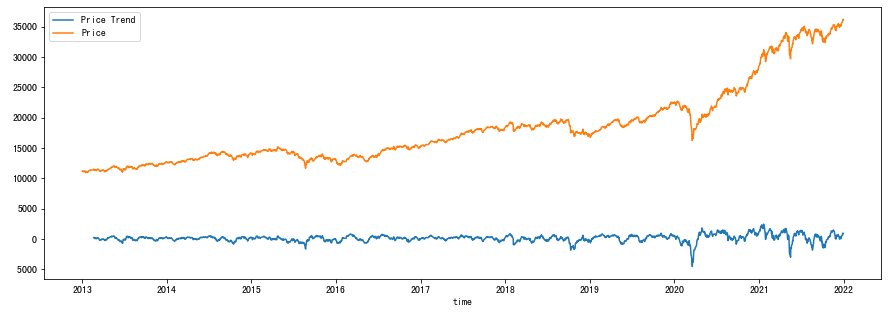

In [16]:
fig = plt.figure(figsize=(15,5))
ax = plt.axes()

# for i in label.index:
ax.plot(pd.to_datetime(df_3.Date), df_3['price_trend'], label='Price Trend')
ax.plot(pd.to_datetime(df_3.Date), df_3['close_adj'], label='Price')

ax.set_xlabel('time')  # Add an x-label to the axes.
# ax.set_ylabel('price')  # Add a y-label to the axes.
ax.legend();  # Add a legend.

In [17]:
df_4 = copy.copy(df_3)
df_4 = df_4.dropna(axis=0)

## 加入其他因子溢酬資料

In [18]:
def extractPremium(name):
    Premium = pd.read_csv('./index_data/'+name+'_Premium.csv')
    Premium.columns = ['年月日', 'HighGroup', 'LowGroup']
    Premium[name+'_Premium'] = Premium.apply(lambda x: x[1]-x[2], axis=1)
    Premium['年月日'] = [i[0:4]+'/'+i[5:7]+'/'+i[8:10] for i in Premium['年月日']]
    return Premium

CTP_Premium = extractPremium('CTP')
EB_Premium = extractPremium('EB')
EP_Premium = extractPremium('EP')
VOL_Premium = extractPremium('VOL')
MOM_Premium = extractPremium('MOM')
SEN_Premium = extractPremium('SEN')
HEAT_Premium = extractPremium('HEAT')
WB_Premium = extractPremium('WB')

In [19]:
df_4 = df_4.merge(CTP_Premium[['年月日', 'CTP_Premium']], on='年月日')
df_4 = df_4.merge(EB_Premium[['年月日', 'EB_Premium']], on='年月日')
df_4 = df_4.merge(EP_Premium[['年月日', 'EP_Premium']], on='年月日')
df_4 = df_4.merge(VOL_Premium[['年月日', 'VOL_Premium']], on='年月日')
df_4 = df_4.merge(MOM_Premium[['年月日', 'MOM_Premium']], on='年月日')
df_4 = df_4.merge(SEN_Premium[['年月日', 'SEN_Premium']], on='年月日')
df_4 = df_4.merge(HEAT_Premium[['年月日', 'HEAT_Premium']], on='年月日')
df_4 = df_4.merge(WB_Premium[['年月日', 'WB_Premium']], on='年月日')

In [20]:
df_4.columns

Index(['年月日', '融資餘額(張)', '融資餘額(千元)', '融券餘額(張)', '融券餘額(千元)', '借券賣出餘額(張)',
       '借券賣出餘額(千元)', '借券賣出可使用額度', '借券賣出限額', '券資比', 'Date', 'close_adj', 'bb',
       '年月', 'EA1101 台灣-景氣對策信號綜合分數-月(分數)', 'EB0308 台灣-原物料價格指數-月(指數)',
       'EB0311 台灣-進口原物料數量指數-月(指數)', 'EB0312 台灣-未來六個月的景氣狀況指數-月(指數)',
       'EB18 台灣-消費者信心指數-月(指數)', 'EB23 台灣-消費者信心指數-未來半年投資股票時機-月(指數)',
       'EC03 台灣-平均薪資-製造業(經季節調整)-台幣-月(元)(TWD)', 'EC08 台灣股價指數變動率-月均值(百分比)',
       'LA07 台灣-失業率-月(百分比)', 'LA0702 台灣-失業率(經季節調整)-月(百分比)',
       'MA1601 台灣-貨幣總計數-M2年增率-期底-月(百分比)', 'PA0110 台灣-CPI總指數(2016=100)-月(指數)',
       'PA0118 台灣-CPI-總指數(經季節調整)(2016=100)-月(指數)', 'Trend', 'Heat', 'Trend2',
       'Heat2', 'price_trend', 'CTP_Premium', 'EB_Premium', 'EP_Premium',
       'VOL_Premium', 'MOM_Premium', 'SEN_Premium', 'HEAT_Premium',
       'WB_Premium'],
      dtype='object')

In [24]:
num = len(df_4.columns)
for i in df_4.columns[ list(range(1, 10))+list(range(14, num)) ]:
    df_4[i] = df_4[i].rolling(window=90).apply(lambda x: np.nanmean(x))

df_4

,年月日,融資餘額(張),融資餘額(千元),融券餘額(張),融券餘額(千元),借券賣出餘額(張),借券賣出餘額(千元),借券賣出可使用額度,借券賣出限額,券資比,...,Heat2,price_trend,CTP_Premium,EB_Premium,EP_Premium,VOL_Premium,MOM_Premium,SEN_Premium,HEAT_Premium,WB_Premium
0,2013/04/01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013/04/02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013/04/03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013/04/08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013/04/09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2145,2021/12/24,9.057075e+06,2.661267e+08,545860.022222,3.193038e+07,1.015650e+07,5.097591e+08,1.520865e+06,7.434455e+07,6.032444,...,0.341441,197.679026,-0.001941,-0.001152,-0.000829,-0.000917,0.001960,-0.000123,0.000096,0.000633
2146,2021/12/27,9.061268e+06,2.662629e+08,546845.444444,3.204910e+07,1.014815e+07,5.101704e+08,1.516746e+06,7.435892e+07,6.040778,...,0.340633,216.249248,-0.001927,-0.001272,-0.000760,-0.000767,0.001595,-0.000127,0.000153,0.000634
2147,2021/12/28,9.065547e+06,2.664246e+08,547537.088889,3.215028e+07,1.013950e+07,5.105673e+08,1.512641e+06,7.437310e+07,6.045889,...,0.340271,246.577663,-0.002013,-0.001068,-0.000550,-0.000967,0.001829,-0.000105,0.000067,0.000661
2148,2021/12/29,9.070291e+06,2.666054e+08,548046.622222,3.225361e+07,1.013127e+07,5.110577e+08,1.508450e+06,7.438945e+07,6.048556,...,0.340005,277.531756,-0.001998,-0.001095,-0.000670,-0.000836,0.001746,-0.000093,0.000066,0.000644


In [30]:
df_4 = df_4.dropna().reset_index(drop=True)

# 季 - Random Forest - All

#### v1: list(range(1, 10))+list(range(24, 27)) 12/23
#### v2: list(range(1, 10))+list(range(14, 27))
#### v3: list(range(1, 10))+list(range(14, num=40))

In [109]:
for i in range(len(df_4.columns)):
    print(i, df_4.columns[i])

0 年月日
1 融資餘額(張)
2 融資餘額(千元)
3 融券餘額(張)
4 融券餘額(千元)
5 借券賣出餘額(張)
6 借券賣出餘額(千元)
7 借券賣出可使用額度
8 借券賣出限額
9 券資比
10 Date
11 close_adj
12 bb
13 年月
14 EA1101 台灣-景氣對策信號綜合分數-月(分數)
15 EB0308 台灣-原物料價格指數-月(指數)
16 EB0311 台灣-進口原物料數量指數-月(指數)
17 EB0312 台灣-未來六個月的景氣狀況指數-月(指數)
18 EB18 台灣-消費者信心指數-月(指數)
19 EB23 台灣-消費者信心指數-未來半年投資股票時機-月(指數)
20 EC03 台灣-平均薪資-製造業(經季節調整)-台幣-月(元)(TWD)
21 EC08 台灣股價指數變動率-月均值(百分比)
22 LA07 台灣-失業率-月(百分比)
23 LA0702 台灣-失業率(經季節調整)-月(百分比)
24 MA1601 台灣-貨幣總計數-M2年增率-期底-月(百分比)
25 PA0110 台灣-CPI總指數(2016=100)-月(指數)
26 PA0118 台灣-CPI-總指數(經季節調整)(2016=100)-月(指數)
27 Trend
28 Heat
29 Trend2
30 Heat2
31 price_trend
32 CTP_Premium
33 EB_Premium
34 EP_Premium
35 VOL_Premium
36 MOM_Premium
37 SEN_Premium
38 HEAT_Premium
39 WB_Premium


# v1

In [115]:
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
import time
from sklearn.ensemble import RandomForestClassifier

num = len(df_4.columns)

def nor(lis):
    lis = lis.astype(float)
    lis = (np.array(lis) - np.nanmean(lis)) / (np.nanvar(lis))**(1/2)
    return lis

for i in df_4.columns[ list(range(1, 10))+list(range(14, num)) ]:
    try:
        df_4[i] = nor(df_4[i])
    except:
        print(i)
        continue

clf1 = RandomForestClassifier(n_estimators=100)
clf5 = RandomForestClassifier(n_estimators=100)
clf10 = RandomForestClassifier(n_estimators=100)
clf15 = RandomForestClassifier(n_estimators=100)
clf20 = RandomForestClassifier(n_estimators=100)
clf30 = RandomForestClassifier(n_estimators=100)
clf60 = RandomForestClassifier(n_estimators=100)
clf90 = RandomForestClassifier(n_estimators=100)

BBPredict = pd.DataFrame(index=df_4.Date, columns=['PredictLabel'])

for year in range(2014, 2022):
# for year in range(2014, 2015):
    for month in [4, 6, 9, 12]: # 3, 5, 8, 11 -> 4, 6, 9, 12
        split = start = end = 0
#         if month == 4:
#             split = df_4[df_4['年月日'] < str(year)+'/04/01'].shape[0] # 3210
#             start = df_4[df_4['年月日'] < str(year-1)+'/12/01'].shape[0] # 3210
#             end = df_4[df_4['年月日'] < str(year)+'/06/01'].shape[0]
#         elif month == 6:
#             split = df_4[df_4['年月日'] < str(year)+'/06/01'].shape[0] # 3210
#             start = df_4[df_4['年月日'] < str(year)+'/04/01'].shape[0] # 3210
#             end = df_4[df_4['年月日'] < str(year)+'/09/01'].shape[0]
#         elif month == 9:
#             split = df_4[df_4['年月日'] < str(year)+'/09/01'].shape[0] # 3210
#             start = df_4[df_4['年月日'] < str(year)+'/06/01'].shape[0] # 3210
#             end = df_4[df_4['年月日'] < str(year)+'/12/01'].shape[0]
#         elif month == 12:
#             split = df_4[df_4['年月日'] < str(year)+'/12/01'].shape[0] # 3210
#             start = df_4[df_4['年月日'] < str(year)+'/09/01'].shape[0] # 3210
#             end = df_4[df_4['年月日'] < str(year+1)+'/04/01'].shape[0]
        
#         start -= 150 ############## start earlier ##############

        if month == 4:
            split = df_4[df_4['年月日'] < str(year)+'/04/01'].shape[0] # 3210
            start = df_4[df_4['年月日'] < str(year-4)+'/04/01'].shape[0] # 3210
            end = df_4[df_4['年月日'] < str(year)+'/06/01'].shape[0]
        elif month == 6:
            split = df_4[df_4['年月日'] < str(year)+'/06/01'].shape[0] # 3210
            start = df_4[df_4['年月日'] < str(year-4)+'/06/01'].shape[0] # 3210
            end = df_4[df_4['年月日'] < str(year)+'/09/01'].shape[0]
        elif month == 9:
            split = df_4[df_4['年月日'] < str(year)+'/09/01'].shape[0] # 3210
            start = df_4[df_4['年月日'] < str(year-4)+'/09/01'].shape[0] # 3210
            end = df_4[df_4['年月日'] < str(year)+'/12/01'].shape[0]
        elif month == 12:
            split = df_4[df_4['年月日'] < str(year)+'/12/01'].shape[0] # 3210
            start = df_4[df_4['年月日'] < str(year-4)+'/12/01'].shape[0] # 3210
            end = df_4[df_4['年月日'] < str(year+1)+'/04/01'].shape[0]
    
#         for delay in [1, 5, 10, 15, 20, 30, 60 ,90]:
        for delay in [1, 5, 10, 15, 20, 30]:
#         for delay in [1]:

            if delay == 1:
                clf = clf1
            elif delay == 5:
                clf = clf5
            elif delay == 10:
                clf = clf10
            elif delay == 15:
                clf = clf15
            elif delay == 20:
                clf = clf20
            elif delay == 30:
                clf = clf30
            elif delay == 60:
                clf = clf60
            elif delay == 90:
                clf = clf90

#             sel = SelectFromModel(clf)
            
#             start = 0 ############## start from the very beginning ##############

            X_train = df_4.iloc[start:split-delay, list(range(1, 10))+list(range(24, 27))].values
            y_train = df_4.iloc[start+delay:split, 12].values
            X_test = df_4.iloc[split-delay:end-delay, list(range(1, 10))+list(range(24, 27))].values
            y_test = df_4.iloc[split:end, 12].values

            print('\n', X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    #         print('\n')

            accuracy_list = []

            for epoch in range(10):
#                 sel.fit(X_train, y_train)
#                 X_train_new = sel.transform(X_train)
#                 clf.fit(X_train_new, y_train)
#                 X_test_new = sel.transform(X_test)
#                 y_predict = clf.predict(X_test_new)
                
                X_train_new = copy.copy(X_train)
                clf.fit(X_train_new, y_train)
                X_test_new = copy.copy(X_test)
                y_predict = clf.predict(X_test_new)


    #             y_predict = clf.predict_proba(X_test_new)
    #             thres = 0.75
    #             y_cut = (y_predict[:,0] > thres) | (y_predict [:,1] > thres) # cut y value and leave the better result
    #             predictions_2 = np.argmax(y_predict[y_cut], axis=-1)
    #             confusionMatrix = confusion_matrix(y_test[y_cut], predictions_2)
                confusionMatrix = confusion_matrix(y_test, y_predict)
#                 print(confusionMatrix)
                try:
                    accuracy = (confusionMatrix[0, 0]+confusionMatrix [1,1])/sum(sum(confusionMatrix))
                except:
#                     print('continue', end=' ')
#                     continue
                    accuracy = 1.0
    #             print(accuracy, end=' ')
                accuracy_list.append(accuracy)
            if len(accuracy_list) > 0:
                print('Year: ', year, 'Month: ', month, 'Delay: ', delay, 'Bull Percentage: ', sum(y_test)/len(y_test), 'Average Accuracy: ', sum(accuracy_list)/len(accuracy_list))
            
            for date_index in range(len(df_4.iloc[split:end, 0])):
                if len(clf.predict_proba(X_test_new)[date_index]) == 2:
                    BBPredict.loc[df_4.iloc[split:end, 0].values[date_index], 'PredictLabel'] = np.append(BBPredict.loc[df_4.iloc[split:end, 0].values[date_index], 'PredictLabel'], str(clf.predict_proba(X_test_new)[date_index][1]))
                else:
                    BBPredict.loc[df_4.iloc[split:end, 0].values[date_index], 'PredictLabel'] = np.append(BBPredict.loc[df_4.iloc[split:end, 0].values[date_index], 'PredictLabel'], str(clf.predict_proba(X_test_new)[date_index][0]))

#             print(y_test, y_predict)
#             print(confusionMatrix)
#             print(clf.feature_importances_)

def NaNmean(x):
    if type(x) != float:
        x = [float(i) for i in x]
        return np.nanmean(x)
    else:
        return float('nan')

def floatlabel(x, delay):
    if type(x) != float:
        delay = -(delay+1)
        x = [float(i) for i in x]
        return x[delay]
    else:
        return float('nan')

BBPredict = BBPredict.fillna(float('nan'))    
BBPredict['PredictLabelMean'] = BBPredict['PredictLabel'].apply(lambda x:NaNmean(x))
BBPredict['PredictLabel1'] = BBPredict['PredictLabel'].apply(lambda x:floatlabel(x, delay=0))
BBPredict['PredictLabel5'] = BBPredict['PredictLabel'].apply(lambda x:floatlabel(x, delay=1))
BBPredict['PredictLabel10'] = BBPredict['PredictLabel'].apply(lambda x:floatlabel(x, delay=2))
BBPredict['PredictLabel15'] = BBPredict['PredictLabel'].apply(lambda x:floatlabel(x, delay=3))
BBPredict['PredictLabel20'] = BBPredict['PredictLabel'].apply(lambda x:floatlabel(x, delay=4))
BBPredict['PredictLabel30'] = BBPredict['PredictLabel'].apply(lambda x:floatlabel(x, delay=5))

df = label.merge(BBPredict, on='Date')
df = df.dropna().reset_index(drop=True)

def intlabel(x, thres):
    if x > thres:
        return 1
    else:
        return 0

for delay in [1, 5, 10, 15, 20, 30]:

    df['PredictLabel' + str(delay) + '_2_int'] = df['PredictLabel' + str(delay)].apply(lambda x: intlabel(x, 0.5))
    confusionMatrix = confusion_matrix(df['bb'], df['PredictLabel' + str(delay) + '_2_int'])
    print(confusionMatrix)
    if confusionMatrix.shape[0] == 2:
        print((confusionMatrix[0,0]+confusionMatrix[1,1])/sum(sum(confusionMatrix)))
    else:
        print((confusionMatrix[1,1]+confusionMatrix[2,2])/sum(sum(confusionMatrix[1:, 1:])))
        
df['PredictLabelMean_2_int'] = df['PredictLabelMean'].apply(lambda x: intlabel(x, 0.5))
confusionMatrix = confusion_matrix(df['bb'], df['PredictLabelMean_2_int'])
print(confusionMatrix)
if confusionMatrix.shape[0] == 2:
    print((confusionMatrix[0,0]+confusionMatrix[1,1])/sum(sum(confusionMatrix)))
else:
    print((confusionMatrix[1,1]+confusionMatrix[2,2])/sum(sum(confusionMatrix[1:, 1:])))
# df['quarterLabel'] = df['PredictLabel30'].apply(lambda x: intlabel(x, 0.3))


 (156, 12) (156,) (42, 12) (42,)
Year:  2014 Month:  4 Delay:  1 Bull Percentage:  0.9285714285714286 Average Accuracy:  0.9285714285714286

 (152, 12) (152,) (42, 12) (42,)
Year:  2014 Month:  4 Delay:  5 Bull Percentage:  0.9285714285714286 Average Accuracy:  0.9285714285714286

 (147, 12) (147,) (42, 12) (42,)
Year:  2014 Month:  4 Delay:  10 Bull Percentage:  0.9285714285714286 Average Accuracy:  0.9285714285714286

 (142, 12) (142,) (42, 12) (42,)
Year:  2014 Month:  4 Delay:  15 Bull Percentage:  0.9285714285714286 Average Accuracy:  0.9285714285714286

 (137, 12) (137,) (42, 12) (42,)
Year:  2014 Month:  4 Delay:  20 Bull Percentage:  0.9285714285714286 Average Accuracy:  0.9285714285714286

 (127, 12) (127,) (42, 12) (42,)
Year:  2014 Month:  4 Delay:  30 Bull Percentage:  0.9285714285714286 Average Accuracy:  0.9285714285714286

 (198, 12) (198,) (63, 12) (63,)
Year:  2014 Month:  6 Delay:  1 Bull Percentage:  1.0 Average Accuracy:  1.0

 (194, 12) (194,) (63, 12) (63,)
Year:

Year:  2016 Month:  12 Delay:  5 Bull Percentage:  0.7721518987341772 Average Accuracy:  0.7721518987341771

 (805, 12) (805,) (79, 12) (79,)
Year:  2016 Month:  12 Delay:  10 Bull Percentage:  0.7721518987341772 Average Accuracy:  0.7721518987341771

 (800, 12) (800,) (79, 12) (79,)
Year:  2016 Month:  12 Delay:  15 Bull Percentage:  0.7721518987341772 Average Accuracy:  0.7721518987341771

 (795, 12) (795,) (79, 12) (79,)
Year:  2016 Month:  12 Delay:  20 Bull Percentage:  0.7721518987341772 Average Accuracy:  0.7721518987341771

 (785, 12) (785,) (79, 12) (79,)
Year:  2016 Month:  12 Delay:  30 Bull Percentage:  0.7721518987341772 Average Accuracy:  0.7721518987341771

 (893, 12) (893,) (38, 12) (38,)
Year:  2017 Month:  4 Delay:  1 Bull Percentage:  0.6842105263157895 Average Accuracy:  0.31578947368421056

 (889, 12) (889,) (38, 12) (38,)
Year:  2017 Month:  4 Delay:  5 Bull Percentage:  0.6842105263157895 Average Accuracy:  0.31578947368421056

 (884, 12) (884,) (38, 12) (38,)
Ye


 (967, 12) (967,) (63, 12) (63,)
Year:  2019 Month:  6 Delay:  15 Bull Percentage:  0.7777777777777778 Average Accuracy:  0.7777777777777778

 (962, 12) (962,) (63, 12) (63,)
Year:  2019 Month:  6 Delay:  20 Bull Percentage:  0.7777777777777778 Average Accuracy:  0.7126984126984126

 (952, 12) (952,) (63, 12) (63,)
Year:  2019 Month:  6 Delay:  30 Bull Percentage:  0.7777777777777778 Average Accuracy:  0.7571428571428571

 (980, 12) (980,) (61, 12) (61,)
Year:  2019 Month:  9 Delay:  1 Bull Percentage:  1.0 Average Accuracy:  0.6344262295081967

 (976, 12) (976,) (61, 12) (61,)
Year:  2019 Month:  9 Delay:  5 Bull Percentage:  1.0 Average Accuracy:  0.9934426229508198

 (971, 12) (971,) (61, 12) (61,)
Year:  2019 Month:  9 Delay:  10 Bull Percentage:  1.0 Average Accuracy:  1.0

 (966, 12) (966,) (61, 12) (61,)
Year:  2019 Month:  9 Delay:  15 Bull Percentage:  1.0 Average Accuracy:  1.0

 (961, 12) (961,) (61, 12) (61,)
Year:  2019 Month:  9 Delay:  20 Bull Percentage:  1.0 Average A

In [118]:
BBPredict.to_csv('BBPredict_v1.csv')

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

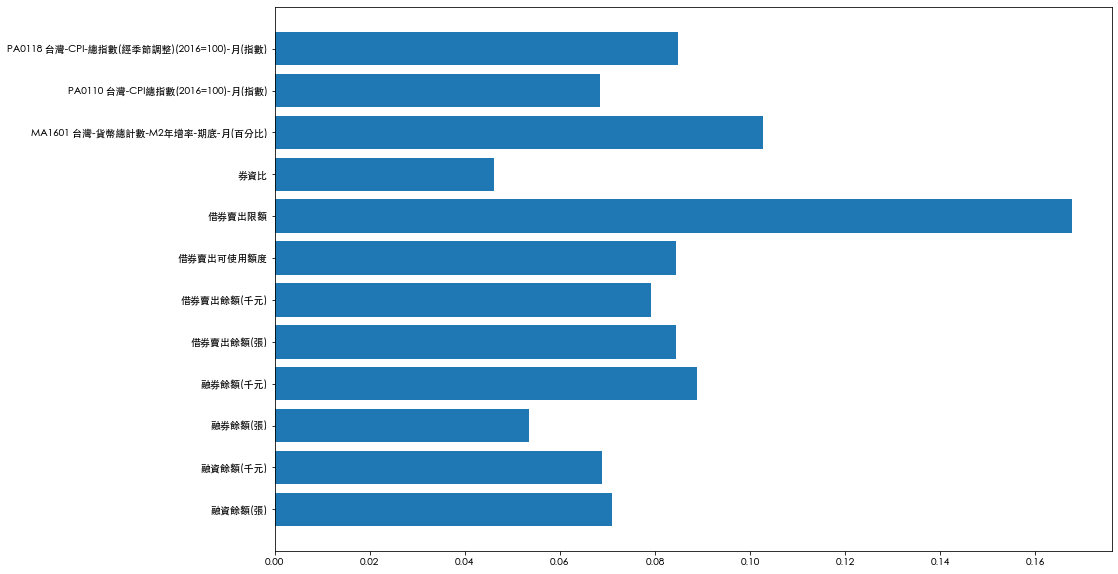

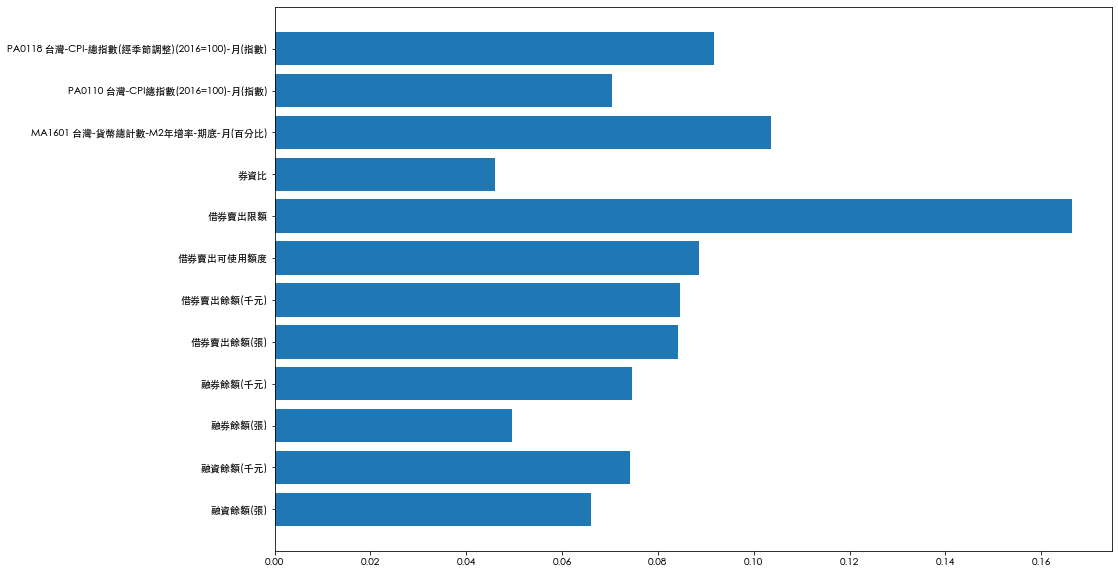

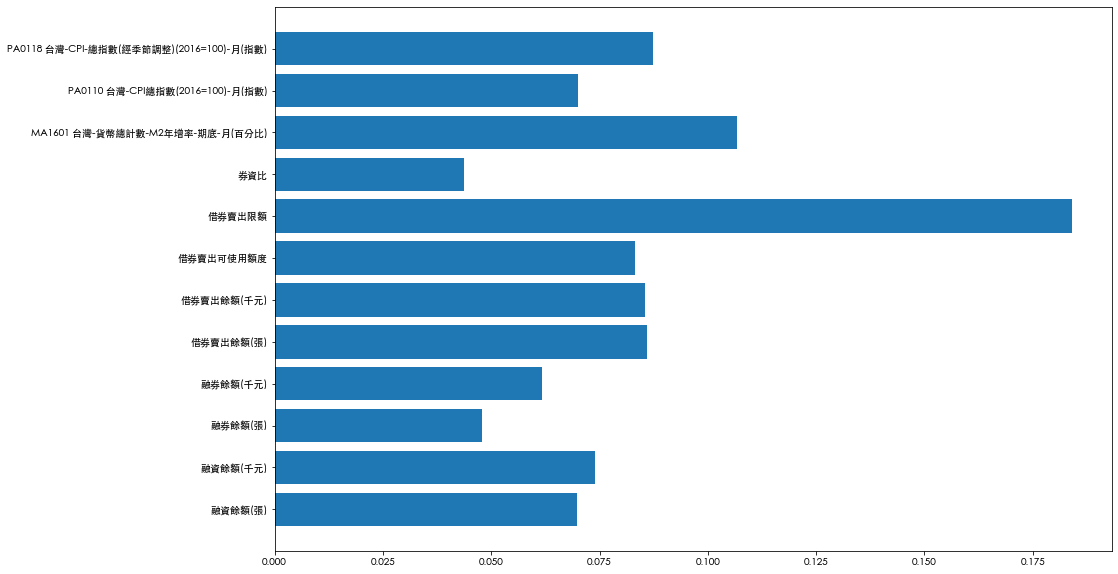

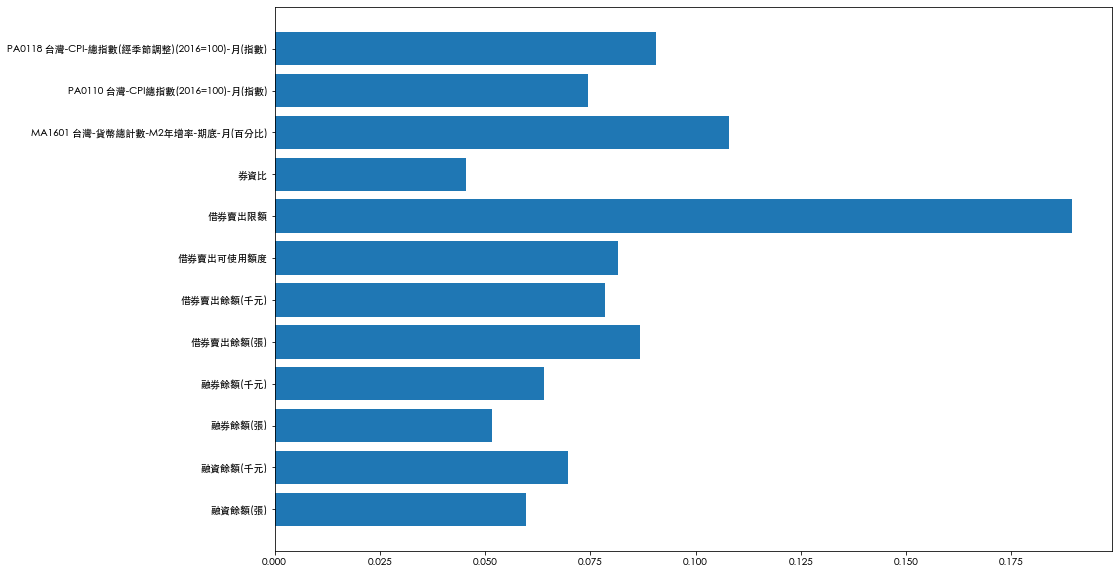

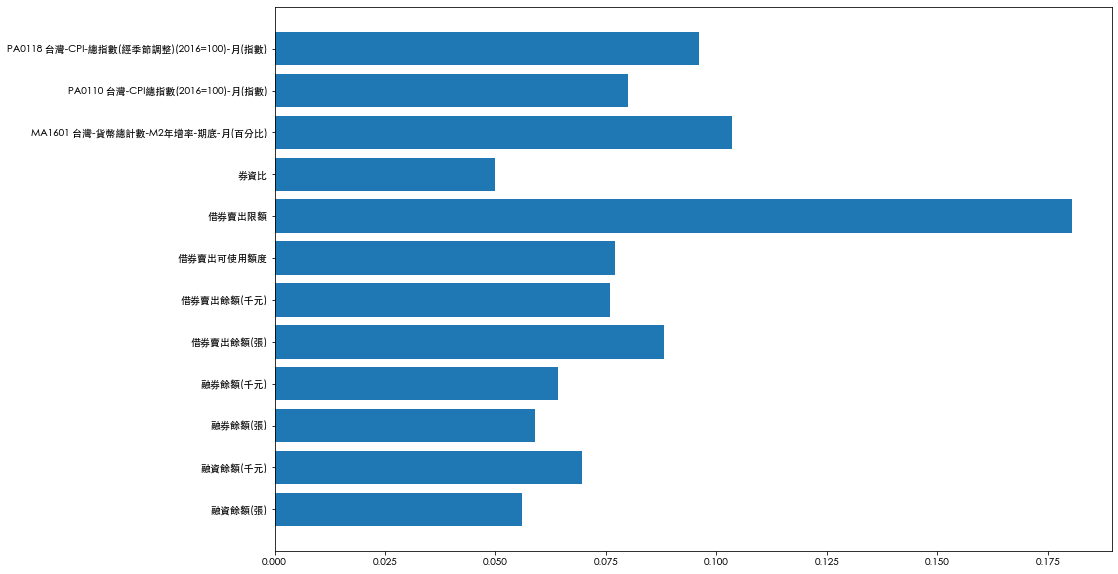

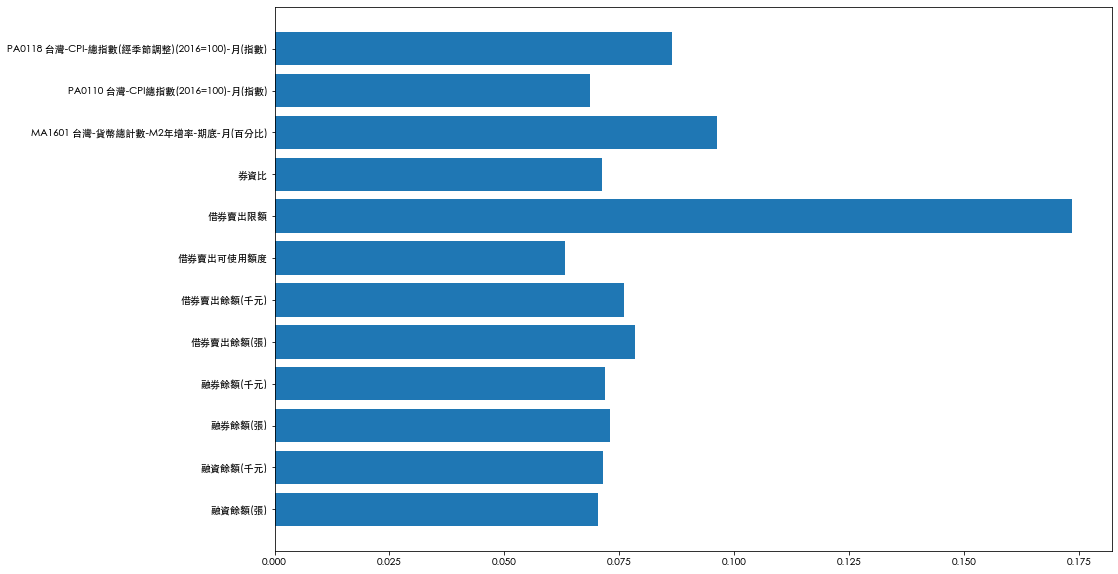

In [114]:
feature_names = df_4.columns[ list(range(1, 10))+list(range(24, 27)) ].values

delay = 30
for delay in [1, 5, 10, 15, 20 ,30]:
    X = df_4.iloc[:-delay, list(range(1, 10))+list(range(24, 27))].values
    y = df_4.iloc[delay:, 12].values
    clf = RandomForestClassifier(n_estimators=100)
    
    feature_importances = np.array([0.0]*12)
    for epoch in range(50):
        print(epoch, end=' ')
        clf.fit(X, y)
        feature_importances += clf.feature_importances_
    #     y_predict = clf.predict(X)
    #     confusionMatrix = confusion_matrix(y, y_predict)
    #     print(confusionMatrix)
    #     print('Accuracy: ', (confusionMatrix[0,0]+confusionMatrix[1,1])/sum(sum(confusionMatrix)))

    plt.figure(figsize=(15,10))
    plt.barh(feature_names, feature_importances/50)

# v2

In [119]:
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
import time
from sklearn.ensemble import RandomForestClassifier

num = len(df_4.columns)

def nor(lis):
    lis = lis.astype(float)
    lis = (np.array(lis) - np.nanmean(lis)) / (np.nanvar(lis))**(1/2)
    return lis

for i in df_4.columns[ list(range(1, 10))+list(range(14, num)) ]:
    try:
        df_4[i] = nor(df_4[i])
    except:
        print(i)
        continue

clf1 = RandomForestClassifier(n_estimators=100)
clf5 = RandomForestClassifier(n_estimators=100)
clf10 = RandomForestClassifier(n_estimators=100)
clf15 = RandomForestClassifier(n_estimators=100)
clf20 = RandomForestClassifier(n_estimators=100)
clf30 = RandomForestClassifier(n_estimators=100)
clf60 = RandomForestClassifier(n_estimators=100)
clf90 = RandomForestClassifier(n_estimators=100)

BBPredict = pd.DataFrame(index=df_4.Date, columns=['PredictLabel'])

for year in range(2014, 2022):
# for year in range(2014, 2015):
    for month in [4, 6, 9, 12]: # 3, 5, 8, 11 -> 4, 6, 9, 12
        split = start = end = 0
#         if month == 4:
#             split = df_4[df_4['年月日'] < str(year)+'/04/01'].shape[0] # 3210
#             start = df_4[df_4['年月日'] < str(year-1)+'/12/01'].shape[0] # 3210
#             end = df_4[df_4['年月日'] < str(year)+'/06/01'].shape[0]
#         elif month == 6:
#             split = df_4[df_4['年月日'] < str(year)+'/06/01'].shape[0] # 3210
#             start = df_4[df_4['年月日'] < str(year)+'/04/01'].shape[0] # 3210
#             end = df_4[df_4['年月日'] < str(year)+'/09/01'].shape[0]
#         elif month == 9:
#             split = df_4[df_4['年月日'] < str(year)+'/09/01'].shape[0] # 3210
#             start = df_4[df_4['年月日'] < str(year)+'/06/01'].shape[0] # 3210
#             end = df_4[df_4['年月日'] < str(year)+'/12/01'].shape[0]
#         elif month == 12:
#             split = df_4[df_4['年月日'] < str(year)+'/12/01'].shape[0] # 3210
#             start = df_4[df_4['年月日'] < str(year)+'/09/01'].shape[0] # 3210
#             end = df_4[df_4['年月日'] < str(year+1)+'/04/01'].shape[0]
        
#         start -= 150 ############## start earlier ##############

        if month == 4:
            split = df_4[df_4['年月日'] < str(year)+'/04/01'].shape[0] # 3210
            start = df_4[df_4['年月日'] < str(year-4)+'/04/01'].shape[0] # 3210
            end = df_4[df_4['年月日'] < str(year)+'/06/01'].shape[0]
        elif month == 6:
            split = df_4[df_4['年月日'] < str(year)+'/06/01'].shape[0] # 3210
            start = df_4[df_4['年月日'] < str(year-4)+'/06/01'].shape[0] # 3210
            end = df_4[df_4['年月日'] < str(year)+'/09/01'].shape[0]
        elif month == 9:
            split = df_4[df_4['年月日'] < str(year)+'/09/01'].shape[0] # 3210
            start = df_4[df_4['年月日'] < str(year-4)+'/09/01'].shape[0] # 3210
            end = df_4[df_4['年月日'] < str(year)+'/12/01'].shape[0]
        elif month == 12:
            split = df_4[df_4['年月日'] < str(year)+'/12/01'].shape[0] # 3210
            start = df_4[df_4['年月日'] < str(year-4)+'/12/01'].shape[0] # 3210
            end = df_4[df_4['年月日'] < str(year+1)+'/04/01'].shape[0]
    
#         for delay in [1, 5, 10, 15, 20, 30, 60 ,90]:
        for delay in [1, 5, 10, 15, 20, 30]:
#         for delay in [1]:

            if delay == 1:
                clf = clf1
            elif delay == 5:
                clf = clf5
            elif delay == 10:
                clf = clf10
            elif delay == 15:
                clf = clf15
            elif delay == 20:
                clf = clf20
            elif delay == 30:
                clf = clf30
            elif delay == 60:
                clf = clf60
            elif delay == 90:
                clf = clf90

#             sel = SelectFromModel(clf)
            
#             start = 0 ############## start from the very beginning ##############

            X_train = df_4.iloc[start:split-delay, list(range(1, 10))+list(range(14, 27))].values
            y_train = df_4.iloc[start+delay:split, 12].values
            X_test = df_4.iloc[split-delay:end-delay, list(range(1, 10))+list(range(14, 27))].values
            y_test = df_4.iloc[split:end, 12].values

            print('\n', X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    #         print('\n')

            accuracy_list = []

            for epoch in range(10):
#                 sel.fit(X_train, y_train)
#                 X_train_new = sel.transform(X_train)
#                 clf.fit(X_train_new, y_train)
#                 X_test_new = sel.transform(X_test)
#                 y_predict = clf.predict(X_test_new)
                
                X_train_new = copy.copy(X_train)
                clf.fit(X_train_new, y_train)
                X_test_new = copy.copy(X_test)
                y_predict = clf.predict(X_test_new)


    #             y_predict = clf.predict_proba(X_test_new)
    #             thres = 0.75
    #             y_cut = (y_predict[:,0] > thres) | (y_predict [:,1] > thres) # cut y value and leave the better result
    #             predictions_2 = np.argmax(y_predict[y_cut], axis=-1)
    #             confusionMatrix = confusion_matrix(y_test[y_cut], predictions_2)
                confusionMatrix = confusion_matrix(y_test, y_predict)
#                 print(confusionMatrix)
                try:
                    accuracy = (confusionMatrix[0, 0]+confusionMatrix [1,1])/sum(sum(confusionMatrix))
                except:
#                     print('continue', end=' ')
#                     continue
                    accuracy = 1.0
    #             print(accuracy, end=' ')
                accuracy_list.append(accuracy)
            if len(accuracy_list) > 0:
                print('Year: ', year, 'Month: ', month, 'Delay: ', delay, 'Bull Percentage: ', sum(y_test)/len(y_test), 'Average Accuracy: ', sum(accuracy_list)/len(accuracy_list))
            
            for date_index in range(len(df_4.iloc[split:end, 0])):
                if len(clf.predict_proba(X_test_new)[date_index]) == 2:
                    BBPredict.loc[df_4.iloc[split:end, 0].values[date_index], 'PredictLabel'] = np.append(BBPredict.loc[df_4.iloc[split:end, 0].values[date_index], 'PredictLabel'], str(clf.predict_proba(X_test_new)[date_index][1]))
                else:
                    BBPredict.loc[df_4.iloc[split:end, 0].values[date_index], 'PredictLabel'] = np.append(BBPredict.loc[df_4.iloc[split:end, 0].values[date_index], 'PredictLabel'], str(clf.predict_proba(X_test_new)[date_index][0]))

#             print(y_test, y_predict)
#             print(confusionMatrix)
#             print(clf.feature_importances_)

def NaNmean(x):
    if type(x) != float:
        x = [float(i) for i in x]
        return np.nanmean(x)
    else:
        return float('nan')

def floatlabel(x, delay):
    if type(x) != float:
        delay = -(delay+1)
        x = [float(i) for i in x]
        return x[delay]
    else:
        return float('nan')

BBPredict = BBPredict.fillna(float('nan'))    
BBPredict['PredictLabelMean'] = BBPredict['PredictLabel'].apply(lambda x:NaNmean(x))
BBPredict['PredictLabel1'] = BBPredict['PredictLabel'].apply(lambda x:floatlabel(x, delay=0))
BBPredict['PredictLabel5'] = BBPredict['PredictLabel'].apply(lambda x:floatlabel(x, delay=1))
BBPredict['PredictLabel10'] = BBPredict['PredictLabel'].apply(lambda x:floatlabel(x, delay=2))
BBPredict['PredictLabel15'] = BBPredict['PredictLabel'].apply(lambda x:floatlabel(x, delay=3))
BBPredict['PredictLabel20'] = BBPredict['PredictLabel'].apply(lambda x:floatlabel(x, delay=4))
BBPredict['PredictLabel30'] = BBPredict['PredictLabel'].apply(lambda x:floatlabel(x, delay=5))

df = label.merge(BBPredict, on='Date')
df = df.dropna().reset_index(drop=True)

def intlabel(x, thres):
    if x > thres:
        return 1
    else:
        return 0

for delay in [1, 5, 10, 15, 20, 30]:

    df['PredictLabel' + str(delay) + '_2_int'] = df['PredictLabel' + str(delay)].apply(lambda x: intlabel(x, 0.5))
    confusionMatrix = confusion_matrix(df['bb'], df['PredictLabel' + str(delay) + '_2_int'])
    print(confusionMatrix)
    if confusionMatrix.shape[0] == 2:
        print((confusionMatrix[0,0]+confusionMatrix[1,1])/sum(sum(confusionMatrix)))
    else:
        print((confusionMatrix[1,1]+confusionMatrix[2,2])/sum(sum(confusionMatrix[1:, 1:])))
        
df['PredictLabelMean_2_int'] = df['PredictLabelMean'].apply(lambda x: intlabel(x, 0.5))
confusionMatrix = confusion_matrix(df['bb'], df['PredictLabelMean_2_int'])
print(confusionMatrix)
if confusionMatrix.shape[0] == 2:
    print((confusionMatrix[0,0]+confusionMatrix[1,1])/sum(sum(confusionMatrix)))
else:
    print((confusionMatrix[1,1]+confusionMatrix[2,2])/sum(sum(confusionMatrix[1:, 1:])))
# df['quarterLabel'] = df['PredictLabel30'].apply(lambda x: intlabel(x, 0.3))


 (156, 22) (156,) (42, 22) (42,)
Year:  2014 Month:  4 Delay:  1 Bull Percentage:  0.9285714285714286 Average Accuracy:  0.9285714285714286

 (152, 22) (152,) (42, 22) (42,)
Year:  2014 Month:  4 Delay:  5 Bull Percentage:  0.9285714285714286 Average Accuracy:  0.9285714285714286

 (147, 22) (147,) (42, 22) (42,)
Year:  2014 Month:  4 Delay:  10 Bull Percentage:  0.9285714285714286 Average Accuracy:  0.9285714285714286

 (142, 22) (142,) (42, 22) (42,)
Year:  2014 Month:  4 Delay:  15 Bull Percentage:  0.9285714285714286 Average Accuracy:  0.9285714285714286

 (137, 22) (137,) (42, 22) (42,)
Year:  2014 Month:  4 Delay:  20 Bull Percentage:  0.9285714285714286 Average Accuracy:  0.9285714285714286

 (127, 22) (127,) (42, 22) (42,)
Year:  2014 Month:  4 Delay:  30 Bull Percentage:  0.9285714285714286 Average Accuracy:  0.9285714285714286

 (198, 22) (198,) (63, 22) (63,)
Year:  2014 Month:  6 Delay:  1 Bull Percentage:  1.0 Average Accuracy:  1.0

 (194, 22) (194,) (63, 22) (63,)
Year:


 (810, 22) (810,) (79, 22) (79,)
Year:  2016 Month:  12 Delay:  5 Bull Percentage:  0.7721518987341772 Average Accuracy:  0.7721518987341771

 (805, 22) (805,) (79, 22) (79,)
Year:  2016 Month:  12 Delay:  10 Bull Percentage:  0.7721518987341772 Average Accuracy:  0.7721518987341771

 (800, 22) (800,) (79, 22) (79,)
Year:  2016 Month:  12 Delay:  15 Bull Percentage:  0.7721518987341772 Average Accuracy:  0.7721518987341771

 (795, 22) (795,) (79, 22) (79,)
Year:  2016 Month:  12 Delay:  20 Bull Percentage:  0.7721518987341772 Average Accuracy:  0.7721518987341771

 (785, 22) (785,) (79, 22) (79,)
Year:  2016 Month:  12 Delay:  30 Bull Percentage:  0.7721518987341772 Average Accuracy:  0.7721518987341771

 (893, 22) (893,) (38, 22) (38,)
Year:  2017 Month:  4 Delay:  1 Bull Percentage:  0.6842105263157895 Average Accuracy:  0.31578947368421056

 (889, 22) (889,) (38, 22) (38,)
Year:  2017 Month:  4 Delay:  5 Bull Percentage:  0.6842105263157895 Average Accuracy:  0.31578947368421056

 


 (972, 22) (972,) (63, 22) (63,)
Year:  2019 Month:  6 Delay:  10 Bull Percentage:  0.7777777777777778 Average Accuracy:  0.7777777777777778

 (967, 22) (967,) (63, 22) (63,)
Year:  2019 Month:  6 Delay:  15 Bull Percentage:  0.7777777777777778 Average Accuracy:  0.7777777777777778

 (962, 22) (962,) (63, 22) (63,)
Year:  2019 Month:  6 Delay:  20 Bull Percentage:  0.7777777777777778 Average Accuracy:  0.7333333333333334

 (952, 22) (952,) (63, 22) (63,)
Year:  2019 Month:  6 Delay:  30 Bull Percentage:  0.7777777777777778 Average Accuracy:  0.7253968253968253

 (980, 22) (980,) (61, 22) (61,)
Year:  2019 Month:  9 Delay:  1 Bull Percentage:  1.0 Average Accuracy:  0.8918032786885245

 (976, 22) (976,) (61, 22) (61,)
Year:  2019 Month:  9 Delay:  5 Bull Percentage:  1.0 Average Accuracy:  1.0

 (971, 22) (971,) (61, 22) (61,)
Year:  2019 Month:  9 Delay:  10 Bull Percentage:  1.0 Average Accuracy:  1.0

 (966, 22) (966,) (61, 22) (61,)
Year:  2019 Month:  9 Delay:  15 Bull Percentage:

In [120]:
BBPredict.to_csv('BBPredict_v2.csv')

# v3

In [121]:
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
import time
from sklearn.ensemble import RandomForestClassifier

num = len(df_4.columns)

def nor(lis):
    lis = lis.astype(float)
    lis = (np.array(lis) - np.nanmean(lis)) / (np.nanvar(lis))**(1/2)
    return lis

for i in df_4.columns[ list(range(1, 10))+list(range(14, num)) ]:
    try:
        df_4[i] = nor(df_4[i])
    except:
        print(i)
        continue

clf1 = RandomForestClassifier(n_estimators=100)
clf5 = RandomForestClassifier(n_estimators=100)
clf10 = RandomForestClassifier(n_estimators=100)
clf15 = RandomForestClassifier(n_estimators=100)
clf20 = RandomForestClassifier(n_estimators=100)
clf30 = RandomForestClassifier(n_estimators=100)
clf60 = RandomForestClassifier(n_estimators=100)
clf90 = RandomForestClassifier(n_estimators=100)

BBPredict = pd.DataFrame(index=df_4.Date, columns=['PredictLabel'])

for year in range(2014, 2022):
# for year in range(2014, 2015):
    for month in [4, 6, 9, 12]: # 3, 5, 8, 11 -> 4, 6, 9, 12
        split = start = end = 0
#         if month == 4:
#             split = df_4[df_4['年月日'] < str(year)+'/04/01'].shape[0] # 3210
#             start = df_4[df_4['年月日'] < str(year-1)+'/12/01'].shape[0] # 3210
#             end = df_4[df_4['年月日'] < str(year)+'/06/01'].shape[0]
#         elif month == 6:
#             split = df_4[df_4['年月日'] < str(year)+'/06/01'].shape[0] # 3210
#             start = df_4[df_4['年月日'] < str(year)+'/04/01'].shape[0] # 3210
#             end = df_4[df_4['年月日'] < str(year)+'/09/01'].shape[0]
#         elif month == 9:
#             split = df_4[df_4['年月日'] < str(year)+'/09/01'].shape[0] # 3210
#             start = df_4[df_4['年月日'] < str(year)+'/06/01'].shape[0] # 3210
#             end = df_4[df_4['年月日'] < str(year)+'/12/01'].shape[0]
#         elif month == 12:
#             split = df_4[df_4['年月日'] < str(year)+'/12/01'].shape[0] # 3210
#             start = df_4[df_4['年月日'] < str(year)+'/09/01'].shape[0] # 3210
#             end = df_4[df_4['年月日'] < str(year+1)+'/04/01'].shape[0]
        
#         start -= 150 ############## start earlier ##############

        if month == 4:
            split = df_4[df_4['年月日'] < str(year)+'/04/01'].shape[0] # 3210
            start = df_4[df_4['年月日'] < str(year-4)+'/04/01'].shape[0] # 3210
            end = df_4[df_4['年月日'] < str(year)+'/06/01'].shape[0]
        elif month == 6:
            split = df_4[df_4['年月日'] < str(year)+'/06/01'].shape[0] # 3210
            start = df_4[df_4['年月日'] < str(year-4)+'/06/01'].shape[0] # 3210
            end = df_4[df_4['年月日'] < str(year)+'/09/01'].shape[0]
        elif month == 9:
            split = df_4[df_4['年月日'] < str(year)+'/09/01'].shape[0] # 3210
            start = df_4[df_4['年月日'] < str(year-4)+'/09/01'].shape[0] # 3210
            end = df_4[df_4['年月日'] < str(year)+'/12/01'].shape[0]
        elif month == 12:
            split = df_4[df_4['年月日'] < str(year)+'/12/01'].shape[0] # 3210
            start = df_4[df_4['年月日'] < str(year-4)+'/12/01'].shape[0] # 3210
            end = df_4[df_4['年月日'] < str(year+1)+'/04/01'].shape[0]
    
#         for delay in [1, 5, 10, 15, 20, 30, 60 ,90]:
        for delay in [1, 5, 10, 15, 20, 30]:
#         for delay in [1]:

            if delay == 1:
                clf = clf1
            elif delay == 5:
                clf = clf5
            elif delay == 10:
                clf = clf10
            elif delay == 15:
                clf = clf15
            elif delay == 20:
                clf = clf20
            elif delay == 30:
                clf = clf30
            elif delay == 60:
                clf = clf60
            elif delay == 90:
                clf = clf90

#             sel = SelectFromModel(clf)
            
#             start = 0 ############## start from the very beginning ##############

            X_train = df_4.iloc[start:split-delay, list(range(1, 10))+list(range(14, num))].values
            y_train = df_4.iloc[start+delay:split, 12].values
            X_test = df_4.iloc[split-delay:end-delay, list(range(1, 10))+list(range(14, num))].values
            y_test = df_4.iloc[split:end, 12].values

            print('\n', X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    #         print('\n')

            accuracy_list = []

            for epoch in range(10):
#                 sel.fit(X_train, y_train)
#                 X_train_new = sel.transform(X_train)
#                 clf.fit(X_train_new, y_train)
#                 X_test_new = sel.transform(X_test)
#                 y_predict = clf.predict(X_test_new)
                
                X_train_new = copy.copy(X_train)
                clf.fit(X_train_new, y_train)
                X_test_new = copy.copy(X_test)
                y_predict = clf.predict(X_test_new)


    #             y_predict = clf.predict_proba(X_test_new)
    #             thres = 0.75
    #             y_cut = (y_predict[:,0] > thres) | (y_predict [:,1] > thres) # cut y value and leave the better result
    #             predictions_2 = np.argmax(y_predict[y_cut], axis=-1)
    #             confusionMatrix = confusion_matrix(y_test[y_cut], predictions_2)
                confusionMatrix = confusion_matrix(y_test, y_predict)
#                 print(confusionMatrix)
                try:
                    accuracy = (confusionMatrix[0, 0]+confusionMatrix [1,1])/sum(sum(confusionMatrix))
                except:
#                     print('continue', end=' ')
#                     continue
                    accuracy = 1.0
    #             print(accuracy, end=' ')
                accuracy_list.append(accuracy)
            if len(accuracy_list) > 0:
                print('Year: ', year, 'Month: ', month, 'Delay: ', delay, 'Bull Percentage: ', sum(y_test)/len(y_test), 'Average Accuracy: ', sum(accuracy_list)/len(accuracy_list))
            
            for date_index in range(len(df_4.iloc[split:end, 0])):
                if len(clf.predict_proba(X_test_new)[date_index]) == 2:
                    BBPredict.loc[df_4.iloc[split:end, 0].values[date_index], 'PredictLabel'] = np.append(BBPredict.loc[df_4.iloc[split:end, 0].values[date_index], 'PredictLabel'], str(clf.predict_proba(X_test_new)[date_index][1]))
                else:
                    BBPredict.loc[df_4.iloc[split:end, 0].values[date_index], 'PredictLabel'] = np.append(BBPredict.loc[df_4.iloc[split:end, 0].values[date_index], 'PredictLabel'], str(clf.predict_proba(X_test_new)[date_index][0]))

#             print(y_test, y_predict)
#             print(confusionMatrix)
#             print(clf.feature_importances_)


 (156, 35) (156,) (42, 35) (42,)
Year:  2014 Month:  4 Delay:  1 Bull Percentage:  0.9285714285714286 Average Accuracy:  0.9285714285714286

 (152, 35) (152,) (42, 35) (42,)
Year:  2014 Month:  4 Delay:  5 Bull Percentage:  0.9285714285714286 Average Accuracy:  0.9285714285714286

 (147, 35) (147,) (42, 35) (42,)
Year:  2014 Month:  4 Delay:  10 Bull Percentage:  0.9285714285714286 Average Accuracy:  0.9285714285714286

 (142, 35) (142,) (42, 35) (42,)
Year:  2014 Month:  4 Delay:  15 Bull Percentage:  0.9285714285714286 Average Accuracy:  0.9285714285714286

 (137, 35) (137,) (42, 35) (42,)
Year:  2014 Month:  4 Delay:  20 Bull Percentage:  0.9285714285714286 Average Accuracy:  0.9285714285714286

 (127, 35) (127,) (42, 35) (42,)
Year:  2014 Month:  4 Delay:  30 Bull Percentage:  0.9285714285714286 Average Accuracy:  0.9285714285714286

 (198, 35) (198,) (63, 35) (63,)
Year:  2014 Month:  6 Delay:  1 Bull Percentage:  1.0 Average Accuracy:  0.9825396825396826

 (194, 35) (194,) (63, 


 (810, 35) (810,) (79, 35) (79,)
Year:  2016 Month:  12 Delay:  5 Bull Percentage:  0.7721518987341772 Average Accuracy:  0.7721518987341771

 (805, 35) (805,) (79, 35) (79,)
Year:  2016 Month:  12 Delay:  10 Bull Percentage:  0.7721518987341772 Average Accuracy:  0.7721518987341771

 (800, 35) (800,) (79, 35) (79,)
Year:  2016 Month:  12 Delay:  15 Bull Percentage:  0.7721518987341772 Average Accuracy:  0.7721518987341771

 (795, 35) (795,) (79, 35) (79,)
Year:  2016 Month:  12 Delay:  20 Bull Percentage:  0.7721518987341772 Average Accuracy:  0.7721518987341771

 (785, 35) (785,) (79, 35) (79,)
Year:  2016 Month:  12 Delay:  30 Bull Percentage:  0.7721518987341772 Average Accuracy:  0.7721518987341771

 (893, 35) (893,) (38, 35) (38,)
Year:  2017 Month:  4 Delay:  1 Bull Percentage:  0.6842105263157895 Average Accuracy:  0.31578947368421056

 (889, 35) (889,) (38, 35) (38,)
Year:  2017 Month:  4 Delay:  5 Bull Percentage:  0.6842105263157895 Average Accuracy:  0.31578947368421056

 

Year:  2019 Month:  6 Delay:  10 Bull Percentage:  0.7777777777777778 Average Accuracy:  0.7777777777777778

 (967, 35) (967,) (63, 35) (63,)
Year:  2019 Month:  6 Delay:  15 Bull Percentage:  0.7777777777777778 Average Accuracy:  0.7444444444444445

 (962, 35) (962,) (63, 35) (63,)
Year:  2019 Month:  6 Delay:  20 Bull Percentage:  0.7777777777777778 Average Accuracy:  0.6666666666666666

 (952, 35) (952,) (63, 35) (63,)
Year:  2019 Month:  6 Delay:  30 Bull Percentage:  0.7777777777777778 Average Accuracy:  0.7539682539682538

 (980, 35) (980,) (61, 35) (61,)
Year:  2019 Month:  9 Delay:  1 Bull Percentage:  1.0 Average Accuracy:  0.8196721311475409

 (976, 35) (976,) (61, 35) (61,)
Year:  2019 Month:  9 Delay:  5 Bull Percentage:  1.0 Average Accuracy:  1.0

 (971, 35) (971,) (61, 35) (61,)
Year:  2019 Month:  9 Delay:  10 Bull Percentage:  1.0 Average Accuracy:  0.9983606557377049

 (966, 35) (966,) (61, 35) (61,)
Year:  2019 Month:  9 Delay:  15 Bull Percentage:  1.0 Average Accur

In [122]:
def NaNmean(x):
    if type(x) != float:
        x = [float(i) for i in x]
        return np.nanmean(x)
    else:
        return float('nan')

def floatlabel(x, delay):
    if type(x) != float:
        delay = -(delay+1)
        x = [float(i) for i in x]
        return x[delay]
    else:
        return float('nan')

BBPredict = BBPredict.fillna(float('nan'))    
BBPredict['PredictLabelMean'] = BBPredict['PredictLabel'].apply(lambda x:NaNmean(x))
BBPredict['PredictLabel1'] = BBPredict['PredictLabel'].apply(lambda x:floatlabel(x, delay=0))
BBPredict['PredictLabel5'] = BBPredict['PredictLabel'].apply(lambda x:floatlabel(x, delay=1))
BBPredict['PredictLabel10'] = BBPredict['PredictLabel'].apply(lambda x:floatlabel(x, delay=2))
BBPredict['PredictLabel15'] = BBPredict['PredictLabel'].apply(lambda x:floatlabel(x, delay=3))
BBPredict['PredictLabel20'] = BBPredict['PredictLabel'].apply(lambda x:floatlabel(x, delay=4))
BBPredict['PredictLabel30'] = BBPredict['PredictLabel'].apply(lambda x:floatlabel(x, delay=5))

df = label.merge(BBPredict, on='Date')
df = df.dropna().reset_index(drop=True)

In [123]:
def intlabel(x, thres):
    if x > thres:
        return 1
    else:
        return 0

for delay in [1, 5, 10, 15, 20, 30]:

    df['PredictLabel' + str(delay) + '_2_int'] = df['PredictLabel' + str(delay)].apply(lambda x: intlabel(x, 0.5))
    confusionMatrix = confusion_matrix(df['bb'], df['PredictLabel' + str(delay) + '_2_int'])
    print(confusionMatrix)
    if confusionMatrix.shape[0] == 2:
        print((confusionMatrix[0,0]+confusionMatrix[1,1])/sum(sum(confusionMatrix)))
    else:
        print((confusionMatrix[1,1]+confusionMatrix[2,2])/sum(sum(confusionMatrix[1:, 1:])))
        
df['PredictLabelMean_2_int'] = df['PredictLabelMean'].apply(lambda x: intlabel(x, 0.5))
confusionMatrix = confusion_matrix(df['bb'], df['PredictLabelMean_2_int'])
print(confusionMatrix)
if confusionMatrix.shape[0] == 2:
    print((confusionMatrix[0,0]+confusionMatrix[1,1])/sum(sum(confusionMatrix)))
else:
    print((confusionMatrix[1,1]+confusionMatrix[2,2])/sum(sum(confusionMatrix[1:, 1:])))
# df['quarterLabel'] = df['PredictLabel30'].apply(lambda x: intlabel(x, 0.3))

[[ 298  251]
 [ 223 1132]]
0.7510504201680672
[[ 303  246]
 [ 208 1147]]
0.7615546218487395
[[ 303  246]
 [ 194 1161]]
0.7689075630252101
[[ 300  249]
 [ 162 1193]]
0.7841386554621849
[[ 304  245]
 [ 231 1124]]
0.75
[[ 309  240]
 [ 224 1131]]
0.7563025210084033
[[ 298  251]
 [ 214 1141]]
0.7557773109243697


In [124]:
BBPredict.to_csv('BBPredict_v3.csv')

In [37]:
# https://hoishing.medium.com/using-chinese-characters-in-matplotlib-5c49dbb6a2f7
import matplotlib
print(matplotlib.matplotlib_fname())
import matplotlib.font_manager
# matplotlib.font_manager._rebuild()
[f for f in matplotlib.font_manager.fontManager.ttflist if 'Heiti' in f.name]
matplotlib.rcParams['font.family'] = ['Heiti TC']

/opt/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/matplotlibrc


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

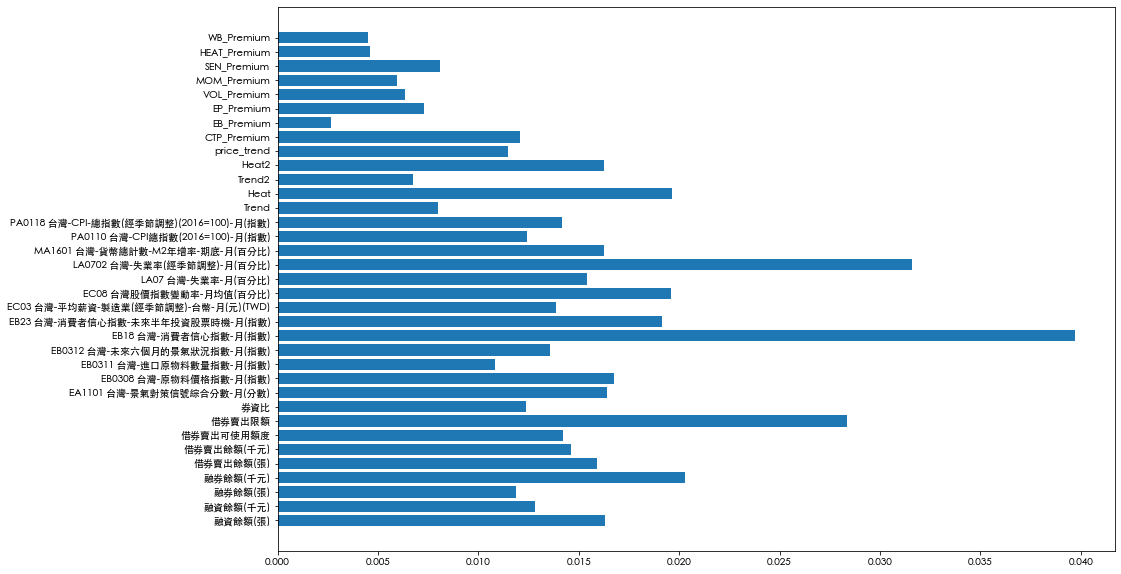

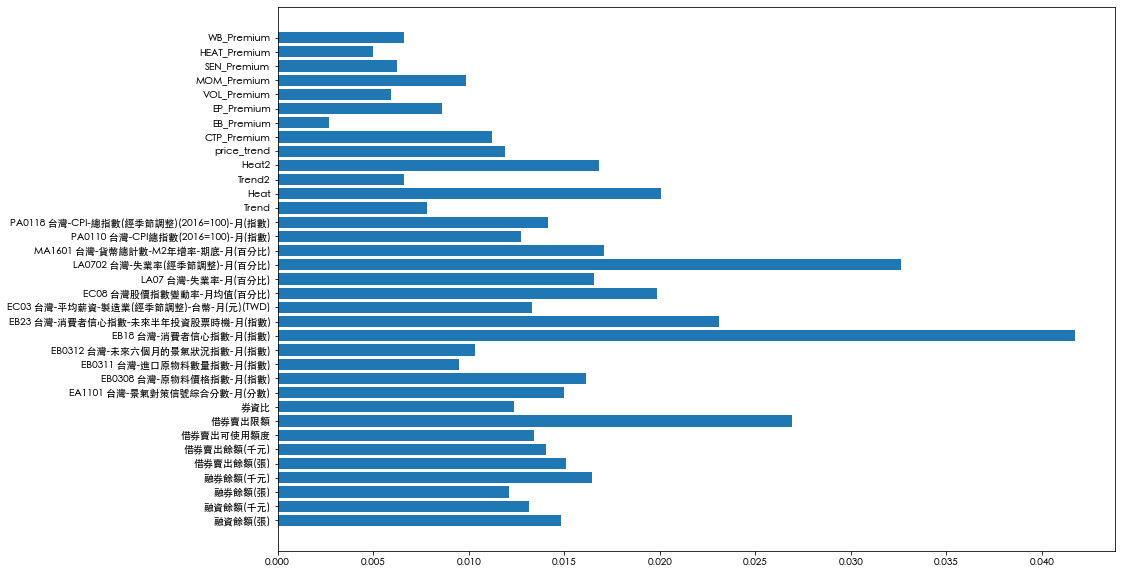

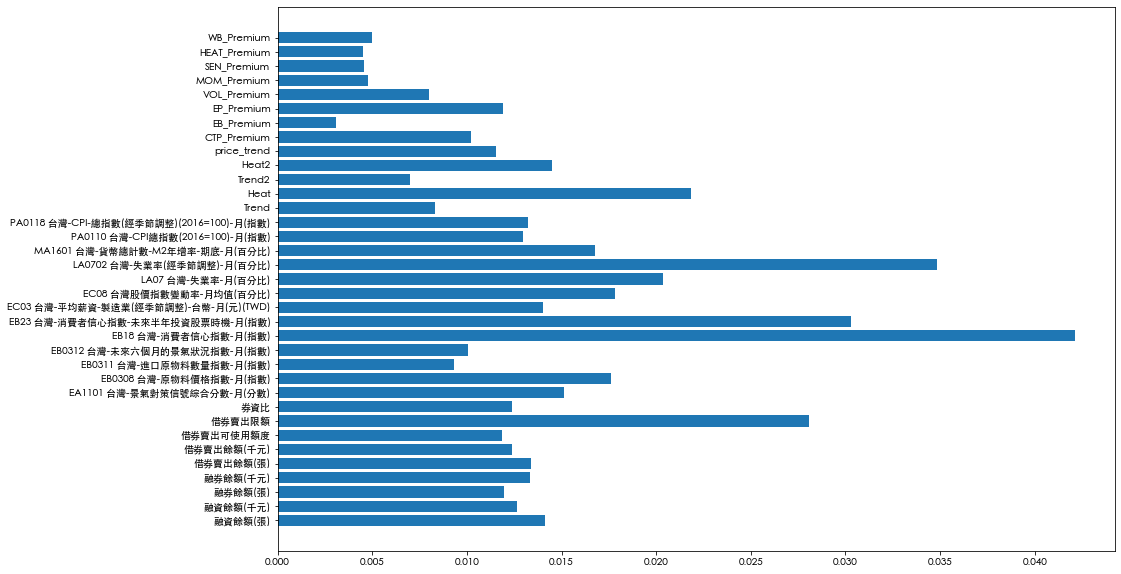

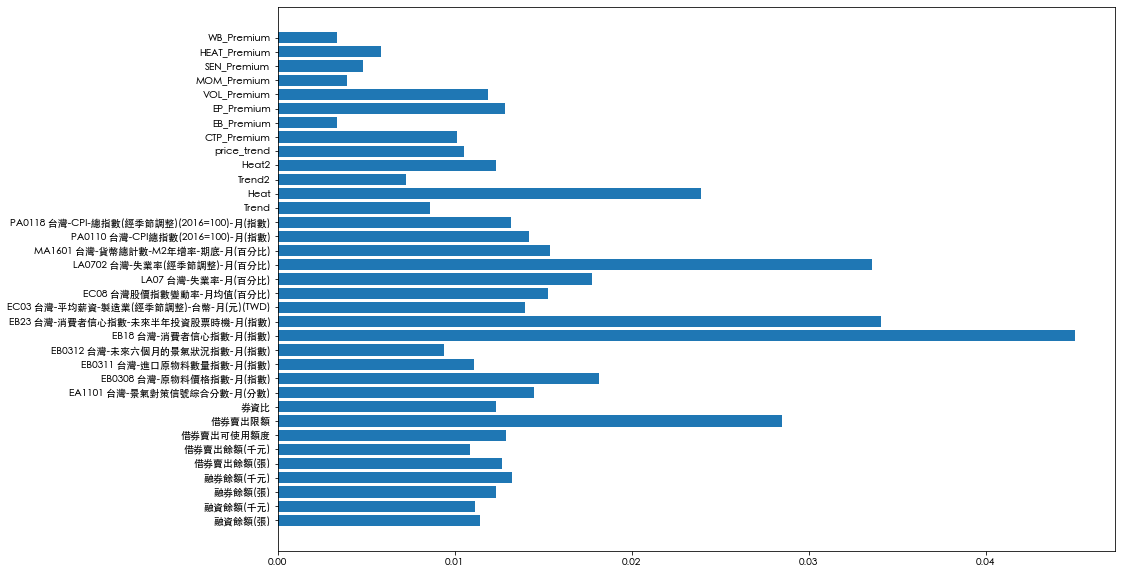

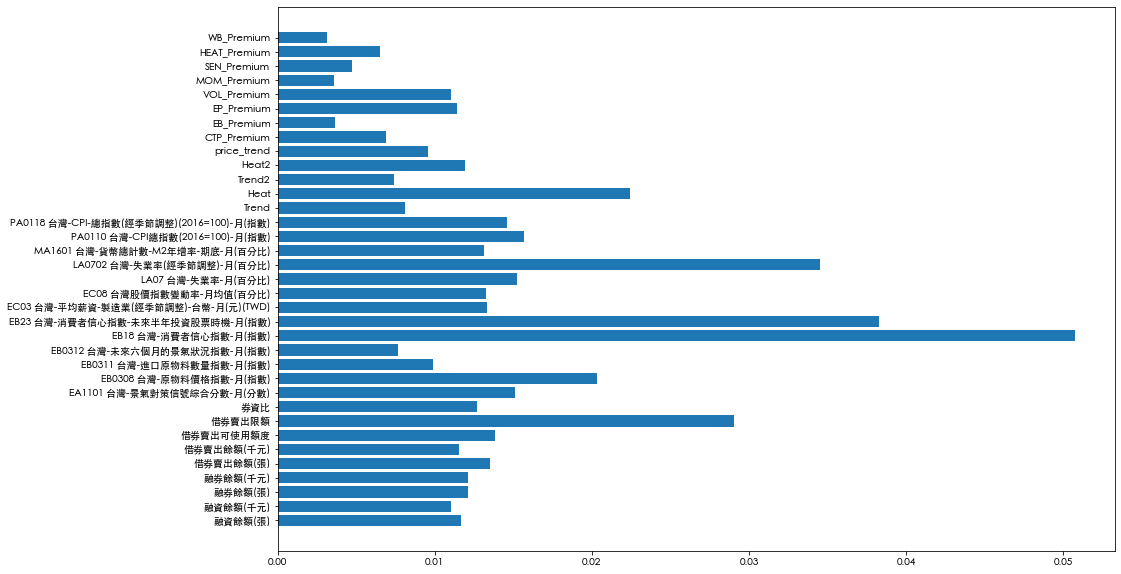

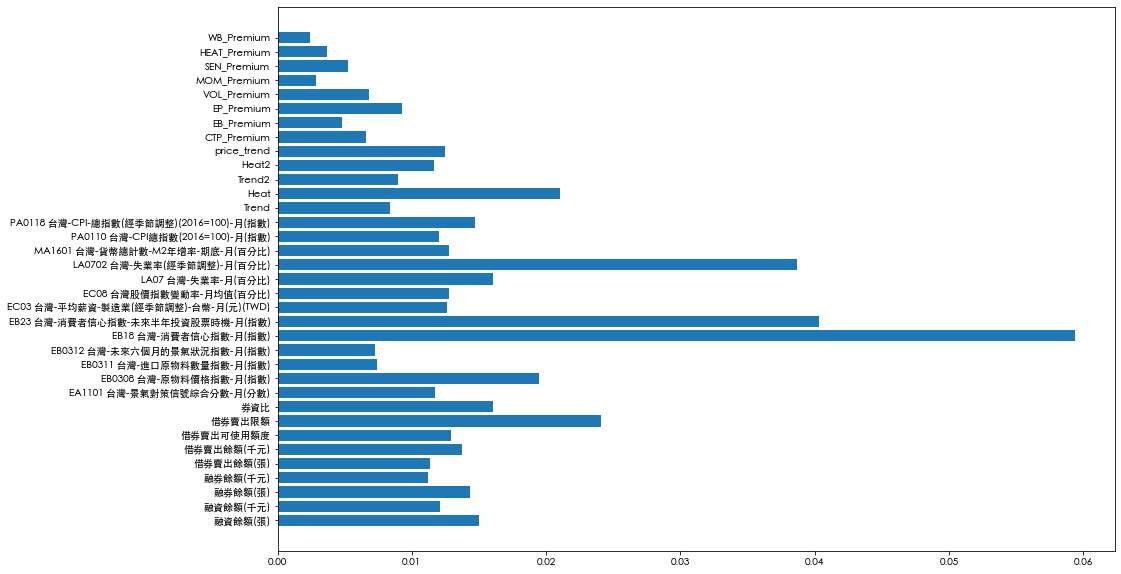

In [97]:
num = len(df_4.columns)
feature_names = df_4.columns[ list(range(1, 10))+list(range(14, num)) ].values

delay = 30
for delay in [1, 5, 10, 15, 20 ,30]:
    X = df_4.iloc[:-delay, list(range(1, 10))+list(range(14, num))].values
    y = df_4.iloc[delay:, 12].values
    clf = RandomForestClassifier(n_estimators=100)
    
    feature_importances = np.array([0.0]*35)
    for epoch in range(50):
        print(epoch, end=' ')
        clf.fit(X, y)
        feature_importances += clf.feature_importances_
    #     y_predict = clf.predict(X)
    #     confusionMatrix = confusion_matrix(y, y_predict)
    #     print(confusionMatrix)
    #     print('Accuracy: ', (confusionMatrix[0,0]+confusionMatrix[1,1])/sum(sum(confusionMatrix)))

    plt.figure(figsize=(15,10))
    plt.barh(feature_names, feature_importances/50)

In [56]:
y = df_4.iloc[delay:, 12].values
sum(y)

1482

# 季 - Random Forest - SFM, RFECV(X, too much time)

In [62]:
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

num = len(df_4.columns)

def nor(lis):
    lis = lis.astype(float)
    lis = (np.array(lis) - np.nanmean(lis)) / (np.nanvar(lis))**(1/2)
    return lis

for i in df_4.columns[ list(range(1, 10))+list(range(14, num)) ]:
    try:
        df_4[i] = nor(df_4[i])
    except:
        print(i)
        continue

clf1 = RandomForestClassifier(n_estimators=100)
clf5 = RandomForestClassifier(n_estimators=100)
clf10 = RandomForestClassifier(n_estimators=100)
clf15 = RandomForestClassifier(n_estimators=100)
clf20 = RandomForestClassifier(n_estimators=100)
clf30 = RandomForestClassifier(n_estimators=100)
clf60 = RandomForestClassifier(n_estimators=100)
clf90 = RandomForestClassifier(n_estimators=100)

BBPredict = pd.DataFrame(index=df_4.Date, columns=['PredictLabel'])

for year in range(2014, 2022):
# for year in range(2014, 2015):
    for month in [4, 6, 9, 12]: # 3, 5, 8, 11 -> 4, 6, 9, 12
        split = start = end = 0
#         if month == 4:
#             split = df_4[df_4['年月日'] < str(year)+'/04/01'].shape[0] # 3210
#             start = df_4[df_4['年月日'] < str(year-1)+'/12/01'].shape[0] # 3210
#             end = df_4[df_4['年月日'] < str(year)+'/06/01'].shape[0]
#         elif month == 6:
#             split = df_4[df_4['年月日'] < str(year)+'/06/01'].shape[0] # 3210
#             start = df_4[df_4['年月日'] < str(year)+'/04/01'].shape[0] # 3210
#             end = df_4[df_4['年月日'] < str(year)+'/09/01'].shape[0]
#         elif month == 9:
#             split = df_4[df_4['年月日'] < str(year)+'/09/01'].shape[0] # 3210
#             start = df_4[df_4['年月日'] < str(year)+'/06/01'].shape[0] # 3210
#             end = df_4[df_4['年月日'] < str(year)+'/12/01'].shape[0]
#         elif month == 12:
#             split = df_4[df_4['年月日'] < str(year)+'/12/01'].shape[0] # 3210
#             start = df_4[df_4['年月日'] < str(year)+'/09/01'].shape[0] # 3210
#             end = df_4[df_4['年月日'] < str(year+1)+'/04/01'].shape[0]
        
#         start -= 150 ############## start earlier ##############

        if month == 4:
            split = df_4[df_4['年月日'] < str(year)+'/04/01'].shape[0] # 3210
            start = df_4[df_4['年月日'] < str(year-4)+'/04/01'].shape[0] # 3210
            end = df_4[df_4['年月日'] < str(year)+'/06/01'].shape[0]
        elif month == 6:
            split = df_4[df_4['年月日'] < str(year)+'/06/01'].shape[0] # 3210
            start = df_4[df_4['年月日'] < str(year-4)+'/06/01'].shape[0] # 3210
            end = df_4[df_4['年月日'] < str(year)+'/09/01'].shape[0]
        elif month == 9:
            split = df_4[df_4['年月日'] < str(year)+'/09/01'].shape[0] # 3210
            start = df_4[df_4['年月日'] < str(year-4)+'/09/01'].shape[0] # 3210
            end = df_4[df_4['年月日'] < str(year)+'/12/01'].shape[0]
        elif month == 12:
            split = df_4[df_4['年月日'] < str(year)+'/12/01'].shape[0] # 3210
            start = df_4[df_4['年月日'] < str(year-4)+'/12/01'].shape[0] # 3210
            end = df_4[df_4['年月日'] < str(year+1)+'/04/01'].shape[0]
    
#         for delay in [1, 5, 10, 15, 20, 30, 60 ,90]:
        for delay in [1, 5, 10, 15, 20, 30]:
#         for delay in [1]:

            if delay == 1:
                clf = clf1
            elif delay == 5:
                clf = clf5
            elif delay == 10:
                clf = clf10
            elif delay == 15:
                clf = clf15
            elif delay == 20:
                clf = clf20
            elif delay == 30:
                clf = clf30
            elif delay == 60:
                clf = clf60
            elif delay == 90:
                clf = clf90

            sel = SelectFromModel(clf)
#             sel = RFECV(clf, cv=5)
            
#             start = 0 ############## start from the very beginning ##############

            X_train = df_4.iloc[start:split-delay, list(range(1, 10))+list(range(14, num))].values
            y_train = df_4.iloc[start+delay:split, 12].values
            X_test = df_4.iloc[split-delay:end-delay, list(range(1, 10))+list(range(14, num))].values
            y_test = df_4.iloc[split:end, 12].values

            print('\n', X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    #         print('\n')

            accuracy_list = []

            for epoch in range(10):
                sel.fit(X_train, y_train)
                X_train_new = sel.transform(X_train)
                clf.fit(X_train_new, y_train)
                X_test_new = sel.transform(X_test)
                y_predict = clf.predict(X_test_new)
                
#                 X_train_new = copy.copy(X_train)
#                 clf.fit(X_train_new, y_train)
#                 X_test_new = copy.copy(X_test)
#                 y_predict = clf.predict(X_test_new)


    #             y_predict = clf.predict_proba(X_test_new)
    #             thres = 0.75
    #             y_cut = (y_predict[:,0] > thres) | (y_predict [:,1] > thres) # cut y value and leave the better result
    #             predictions_2 = np.argmax(y_predict[y_cut], axis=-1)
    #             confusionMatrix = confusion_matrix(y_test[y_cut], predictions_2)
                confusionMatrix = confusion_matrix(y_test, y_predict)
#                 print(confusionMatrix)
                try:
                    accuracy = (confusionMatrix[0, 0]+confusionMatrix [1,1])/sum(sum(confusionMatrix))
                except:
#                     print('continue', end=' ')
#                     continue
                    accuracy = 1.0
    #             print(accuracy, end=' ')
                accuracy_list.append(accuracy)
            if len(accuracy_list) > 0:
                print('Year: ', year, 'Month: ', month, 'Delay: ', delay, 'Bull Percentage: ', sum(y_test)/len(y_test), 'Average Accuracy: ', sum(accuracy_list)/len(accuracy_list))
            
            for date_index in range(len(df_4.iloc[split:end, 0])):
                if len(clf.predict_proba(X_test_new)[date_index]) == 2:
                    BBPredict.loc[df_4.iloc[split:end, 0].values[date_index], 'PredictLabel'] = np.append(BBPredict.loc[df_4.iloc[split:end, 0].values[date_index], 'PredictLabel'], str(clf.predict_proba(X_test_new)[date_index][1]))
                else:
                    BBPredict.loc[df_4.iloc[split:end, 0].values[date_index], 'PredictLabel'] = np.append(BBPredict.loc[df_4.iloc[split:end, 0].values[date_index], 'PredictLabel'], str(clf.predict_proba(X_test_new)[date_index][0]))

#             print(y_test, y_predict)
#             print(confusionMatrix)
#             print(clf.feature_importances_)


 (156, 35) (156,) (42, 35) (42,)
Year:  2014 Month:  4 Delay:  1 Bull Percentage:  0.9285714285714286 Average Accuracy:  0.9285714285714286

 (152, 35) (152,) (42, 35) (42,)
Year:  2014 Month:  4 Delay:  5 Bull Percentage:  0.9285714285714286 Average Accuracy:  0.9285714285714286

 (147, 35) (147,) (42, 35) (42,)
Year:  2014 Month:  4 Delay:  10 Bull Percentage:  0.9285714285714286 Average Accuracy:  0.9285714285714286

 (142, 35) (142,) (42, 35) (42,)
Year:  2014 Month:  4 Delay:  15 Bull Percentage:  0.9285714285714286 Average Accuracy:  0.9285714285714286

 (137, 35) (137,) (42, 35) (42,)
Year:  2014 Month:  4 Delay:  20 Bull Percentage:  0.9285714285714286 Average Accuracy:  0.9285714285714286

 (127, 35) (127,) (42, 35) (42,)
Year:  2014 Month:  4 Delay:  30 Bull Percentage:  0.9285714285714286 Average Accuracy:  0.9285714285714286

 (198, 35) (198,) (63, 35) (63,)
Year:  2014 Month:  6 Delay:  1 Bull Percentage:  1.0 Average Accuracy:  0.9920634920634921

 (194, 35) (194,) (63, 

Year:  2016 Month:  12 Delay:  1 Bull Percentage:  0.7721518987341772 Average Accuracy:  0.8012658227848102

 (810, 35) (810,) (79, 35) (79,)
Year:  2016 Month:  12 Delay:  5 Bull Percentage:  0.7721518987341772 Average Accuracy:  0.7721518987341771

 (805, 35) (805,) (79, 35) (79,)
Year:  2016 Month:  12 Delay:  10 Bull Percentage:  0.7721518987341772 Average Accuracy:  0.7721518987341771

 (800, 35) (800,) (79, 35) (79,)
Year:  2016 Month:  12 Delay:  15 Bull Percentage:  0.7721518987341772 Average Accuracy:  0.7721518987341771

 (795, 35) (795,) (79, 35) (79,)
Year:  2016 Month:  12 Delay:  20 Bull Percentage:  0.7721518987341772 Average Accuracy:  0.7721518987341771

 (785, 35) (785,) (79, 35) (79,)
Year:  2016 Month:  12 Delay:  30 Bull Percentage:  0.7721518987341772 Average Accuracy:  0.7721518987341771

 (893, 35) (893,) (38, 35) (38,)
Year:  2017 Month:  4 Delay:  1 Bull Percentage:  0.6842105263157895 Average Accuracy:  0.31578947368421056

 (889, 35) (889,) (38, 35) (38,)
Ye


 (977, 35) (977,) (63, 35) (63,)
Year:  2019 Month:  6 Delay:  5 Bull Percentage:  0.7777777777777778 Average Accuracy:  0.7793650793650794

 (972, 35) (972,) (63, 35) (63,)
Year:  2019 Month:  6 Delay:  10 Bull Percentage:  0.7777777777777778 Average Accuracy:  0.7777777777777778

 (967, 35) (967,) (63, 35) (63,)
Year:  2019 Month:  6 Delay:  15 Bull Percentage:  0.7777777777777778 Average Accuracy:  0.7777777777777778

 (962, 35) (962,) (63, 35) (63,)
Year:  2019 Month:  6 Delay:  20 Bull Percentage:  0.7777777777777778 Average Accuracy:  0.7206349206349205

 (952, 35) (952,) (63, 35) (63,)
Year:  2019 Month:  6 Delay:  30 Bull Percentage:  0.7777777777777778 Average Accuracy:  0.7841269841269841

 (980, 35) (980,) (61, 35) (61,)
Year:  2019 Month:  9 Delay:  1 Bull Percentage:  1.0 Average Accuracy:  0.9672131147540984

 (976, 35) (976,) (61, 35) (61,)
Year:  2019 Month:  9 Delay:  5 Bull Percentage:  1.0 Average Accuracy:  1.0

 (971, 35) (971,) (61, 35) (61,)
Year:  2019 Month:  

In [63]:
def NaNmean(x):
    if type(x) != float:
        x = [float(i) for i in x]
        return np.nanmean(x)
    else:
        return float('nan')

def floatlabel(x, delay):
    if type(x) != float:
        delay = -(delay+1)
        x = [float(i) for i in x]
        return x[delay]
    else:
        return float('nan')

BBPredict = BBPredict.fillna(float('nan'))    
BBPredict['PredictLabelMean'] = BBPredict['PredictLabel'].apply(lambda x:NaNmean(x))
BBPredict['PredictLabel1'] = BBPredict['PredictLabel'].apply(lambda x:floatlabel(x, delay=0))
BBPredict['PredictLabel5'] = BBPredict['PredictLabel'].apply(lambda x:floatlabel(x, delay=1))
BBPredict['PredictLabel10'] = BBPredict['PredictLabel'].apply(lambda x:floatlabel(x, delay=2))
BBPredict['PredictLabel15'] = BBPredict['PredictLabel'].apply(lambda x:floatlabel(x, delay=3))
BBPredict['PredictLabel20'] = BBPredict['PredictLabel'].apply(lambda x:floatlabel(x, delay=4))
BBPredict['PredictLabel30'] = BBPredict['PredictLabel'].apply(lambda x:floatlabel(x, delay=5))

df = label.merge(BBPredict, on='Date')
df = df.dropna().reset_index(drop=True)
df

,X,Date,close_adj,volume,algoDefine,bb,PredictLabel,PredictLabelMean,PredictLabel1,PredictLabel5,PredictLabel10,PredictLabel15,PredictLabel20,PredictLabel30
0,1550,2014/04/01,13109.80,4607052,True,1,"[nan, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",1.000000,1.0,1.00,1.00,1.00,1.0,1.00
1,1551,2014/04/02,13157.54,5131398,True,1,"[nan, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",1.000000,1.0,1.00,1.00,1.00,1.0,1.00
2,1552,2014/04/03,13132.55,4817592,True,1,"[nan, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",1.000000,1.0,1.00,1.00,1.00,1.0,1.00
3,1553,2014/04/07,13114.68,4514514,True,1,"[nan, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",1.000000,1.0,1.00,1.00,1.00,1.0,1.00
4,1554,2014/04/08,13132.12,4502406,True,1,"[nan, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",1.000000,1.0,1.00,1.00,1.00,1.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,3449,2021/12/24,35628.29,6294056,True,1,"[nan, 0.79, 1.0, 0.99, 0.99, 0.95, 1.0]",0.953333,1.0,0.95,0.99,0.99,1.0,0.79
1900,3450,2021/12/27,35801.46,6063084,True,1,"[nan, 0.81, 1.0, 0.99, 0.99, 0.94, 1.0]",0.955000,1.0,0.94,0.99,0.99,1.0,0.81
1901,3451,2021/12/28,36094.77,6288478,True,1,"[nan, 0.81, 1.0, 0.99, 0.99, 0.94, 1.0]",0.955000,1.0,0.94,0.99,0.99,1.0,0.81
1902,3452,2021/12/29,36196.87,6188965,True,1,"[nan, 0.81, 1.0, 0.99, 0.99, 0.94, 1.0]",0.955000,1.0,0.94,0.99,0.99,1.0,0.81


In [64]:
def intlabel(x, thres):
    if x > thres:
        return 1
    else:
        return 0

for delay in [1, 5, 10, 15, 20, 30]:

    df['PredictLabel' + str(delay) + '_2_int'] = df['PredictLabel' + str(delay)].apply(lambda x: intlabel(x, 0.5))
    confusionMatrix = confusion_matrix(df['bb'], df['PredictLabel' + str(delay) + '_2_int'])
    print(confusionMatrix)
    if confusionMatrix.shape[0] == 2:
        print((confusionMatrix[0,0]+confusionMatrix[1,1])/sum(sum(confusionMatrix)))
    else:
        print((confusionMatrix[1,1]+confusionMatrix[2,2])/sum(sum(confusionMatrix[1:, 1:])))
        
df['PredictLabelMean_2_int'] = df['PredictLabelMean'].apply(lambda x: intlabel(x, 0.5))
confusionMatrix = confusion_matrix(df['bb'], df['PredictLabelMean_2_int'])
print(confusionMatrix)
if confusionMatrix.shape[0] == 2:
    print((confusionMatrix[0,0]+confusionMatrix[1,1])/sum(sum(confusionMatrix)))
else:
    print((confusionMatrix[1,1]+confusionMatrix[2,2])/sum(sum(confusionMatrix[1:, 1:])))
# df['quarterLabel'] = df['PredictLabel30'].apply(lambda x: intlabel(x, 0.3))

[[ 271  278]
 [ 233 1122]]
0.7316176470588235
[[ 280  269]
 [ 212 1143]]
0.7473739495798319
[[ 302  247]
 [ 232 1123]]
0.7484243697478992
[[ 258  291]
 [ 204 1151]]
0.7400210084033614
[[ 308  241]
 [ 229 1126]]
0.7531512605042017
[[ 299  250]
 [ 204 1151]]
0.7615546218487395
[[ 298  251]
 [ 210 1145]]
0.7578781512605042


1502
1502
[[ 558    0]
 [   0 1502]]
Accuracy:  1.0


<BarContainer object of 12 artists>

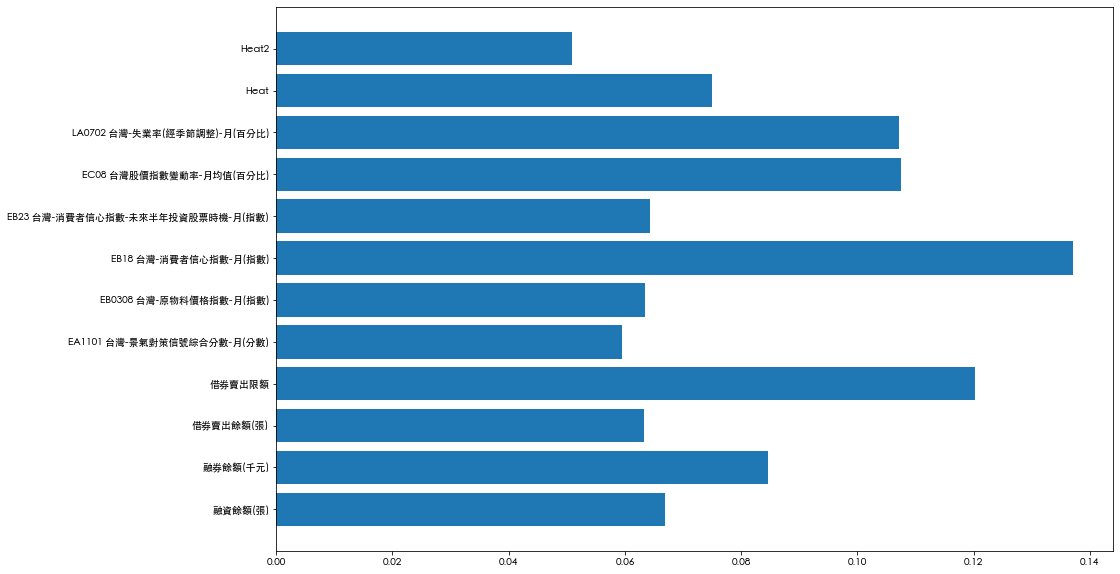

In [61]:
num = len(df_4.columns)
feature_names = df_4.columns[ list(range(1, 10))+list(range(14, num)) ].values
sel = SelectFromModel(clf)

delay = 1
X = df_4.iloc[:-delay, list(range(1, 10))+list(range(14, num))].values
y = df_4.iloc[delay:, 12].values
print(sum(y))
X_new = sel.fit_transform(X, y)
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_new, y)
y_predict = clf.predict(X_new)
confusionMatrix = confusion_matrix(y, y_predict)
print(sum(y))
print(confusionMatrix)
print('Accuracy: ', (confusionMatrix[0,0]+confusionMatrix[1,1])/sum(sum(confusionMatrix)))
plt.figure(figsize=(15,10))
plt.barh(sel.get_feature_names_out(feature_names), clf.feature_importances_)

# 季 - Logistic Regression... - All


In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix

num = len(df_4.columns)

def nor(lis):
    lis = lis.astype(float)
    lis = (np.array(lis) - np.nanmean(lis)) / (np.nanvar(lis))**(1/2)
    return lis

for i in df_4.columns[ list(range(1, 10))+list(range(14, num)) ]:
    try:
        df_4[i] = nor(df_4[i])
    except:
        print(i)
        continue

# otherAI = SVC(probability=True)
otherAI = LogisticRegression()
clf1 = clf5 = clf10 = clf15 = clf20 = clf30 = clf60 = clf90 = otherAI


BBPredict = pd.DataFrame(index=df_4.Date, columns=['PredictLabel'])

for year in range(2014, 2022):
# for year in range(2014, 2015):
    for month in [4, 6, 9, 12]: # 3, 5, 8, 11 -> 4, 6, 9, 12
        split = start = end = 0

        if month == 4:
            split = df_4[df_4['年月日'] < str(year)+'/04/01'].shape[0] # 3210
            start = df_4[df_4['年月日'] < str(year-4)+'/04/01'].shape[0] # 3210
            end = df_4[df_4['年月日'] < str(year)+'/06/01'].shape[0]
        elif month == 6:
            split = df_4[df_4['年月日'] < str(year)+'/06/01'].shape[0] # 3210
            start = df_4[df_4['年月日'] < str(year-4)+'/06/01'].shape[0] # 3210
            end = df_4[df_4['年月日'] < str(year)+'/09/01'].shape[0]
        elif month == 9:
            split = df_4[df_4['年月日'] < str(year)+'/09/01'].shape[0] # 3210
            start = df_4[df_4['年月日'] < str(year-4)+'/09/01'].shape[0] # 3210
            end = df_4[df_4['年月日'] < str(year)+'/12/01'].shape[0]
        elif month == 12:
            split = df_4[df_4['年月日'] < str(year)+'/12/01'].shape[0] # 3210
            start = df_4[df_4['年月日'] < str(year-4)+'/12/01'].shape[0] # 3210
            end = df_4[df_4['年月日'] < str(year+1)+'/04/01'].shape[0]
    
        for delay in [1, 5, 10, 15, 20, 30]:

            if delay == 1:
                clf = clf1
            elif delay == 5:
                clf = clf5
            elif delay == 10:
                clf = clf10
            elif delay == 15:
                clf = clf15
            elif delay == 20:
                clf = clf20
            elif delay == 30:
                clf = clf30
            elif delay == 60:
                clf = clf60
            elif delay == 90:
                clf = clf90
            
#             start = 0 ############## start from the very beginning ##############

            X_train = df_4.iloc[start:split-delay, list(range(1, 10))+list(range(14, num))].values
            y_train = df_4.iloc[start+delay:split, 12].values
            X_test = df_4.iloc[split-delay:end-delay, list(range(1, 10))+list(range(14, num))].values
            y_test = df_4.iloc[split:end, 12].values

            print('\n', X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    #         print('\n')

            accuracy_list = []

            for epoch in range(10):
#                 sel.fit(X_train, y_train)
#                 X_train_new = sel.transform(X_train)
#                 clf.fit(X_train_new, y_train)
#                 X_test_new = sel.transform(X_test)
#                 y_predict = clf.predict(X_test_new)
                
                X_train_new = copy.copy(X_train)
                if sum(y_train) != len(y_train):
                    clf.fit(X_train_new, y_train)
                else:
                    pass
                X_test_new = copy.copy(X_test)
                y_predict = clf.predict(X_test_new)
    
                confusionMatrix = confusion_matrix(y_test, y_predict)
#                 print(confusionMatrix)
                try:
                    accuracy = (confusionMatrix[0, 0]+confusionMatrix [1,1])/sum(sum(confusionMatrix))
                except:
#                     print('continue', end=' ')
#                     continue
                    accuracy = 1.0
    #             print(accuracy, end=' ')
                accuracy_list.append(accuracy)
            if len(accuracy_list) > 0:
                print('Year: ', year, 'Month: ', month, 'Delay: ', delay, 'Bull Percentage: ', sum(y_test)/len(y_test), 'Average Accuracy: ', sum(accuracy_list)/len(accuracy_list))
            
            for date_index in range(len(df_4.iloc[split:end, 0])):
                if len(clf.predict_proba(X_test_new)[date_index]) == 2:
                    BBPredict.loc[df_4.iloc[split:end, 0].values[date_index], 'PredictLabel'] = np.append(BBPredict.loc[df_4.iloc[split:end, 0].values[date_index], 'PredictLabel'], str(clf.predict_proba(X_test_new)[date_index][1]))
                else:
                    BBPredict.loc[df_4.iloc[split:end, 0].values[date_index], 'PredictLabel'] = np.append(BBPredict.loc[df_4.iloc[split:end, 0].values[date_index], 'PredictLabel'], str(clf.predict_proba(X_test_new)[date_index][0]))


 (156, 35) (156,) (42, 35) (42,)
Year:  2014 Month:  4 Delay:  1 Bull Percentage:  0.9285714285714286 Average Accuracy:  0.9285714285714286

 (152, 35) (152,) (42, 35) (42,)
Year:  2014 Month:  4 Delay:  5 Bull Percentage:  0.9285714285714286 Average Accuracy:  0.9285714285714286

 (147, 35) (147,) (42, 35) (42,)
Year:  2014 Month:  4 Delay:  10 Bull Percentage:  0.9285714285714286 Average Accuracy:  0.9285714285714286

 (142, 35) (142,) (42, 35) (42,)
Year:  2014 Month:  4 Delay:  15 Bull Percentage:  0.9285714285714286 Average Accuracy:  0.9285714285714286

 (137, 35) (137,) (42, 35) (42,)
Year:  2014 Month:  4 Delay:  20 Bull Percentage:  0.9285714285714286 Average Accuracy:  0.9285714285714286

 (127, 35) (127,) (42, 35) (42,)
Year:  2014 Month:  4 Delay:  30 Bull Percentage:  0.9285714285714286 Average Accuracy:  0.9285714285714286

 (198, 35) (198,) (63, 35) (63,)
Year:  2014 Month:  6 Delay:  1 Bull Percentage:  1.0 Average Accuracy:  0.7619047619047619

 (194, 35) (194,) (63, 

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2016 Month:  4 Delay:  5 Bull Percentage:  0.525 Average Accuracy:  0.29999999999999993

 (640, 35) (640,) (40, 35) (40,)
Year:  2016 Month:  4 Delay:  10 Bull Percentage:  0.525 Average Accuracy:  0.5250000000000001

 (635, 35) (635,) (40, 35) (40,)
Year:  2016 Month:  4 Delay:  15 Bull Percentage:  0.525 Average Accuracy:  0.5250000000000001

 (630, 35) (630,) (40, 35) (40,)
Year:  2016 Month:  4 Delay:  20 Bull Percentage:  0.525 Average Accuracy:  0.5250000000000001

 (620, 35) (620,) (40, 35) (40,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2016 Month:  4 Delay:  30 Bull Percentage:  0.525 Average Accuracy:  0.5250000000000001

 (689, 35) (689,) (64, 35) (64,)
Year:  2016 Month:  6 Delay:  1 Bull Percentage:  1.0 Average Accuracy:  0.0


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_


 (685, 35) (685,) (64, 35) (64,)
Year:  2016 Month:  6 Delay:  5 Bull Percentage:  1.0 Average Accuracy:  0.046875


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_


 (680, 35) (680,) (64, 35) (64,)
Year:  2016 Month:  6 Delay:  10 Bull Percentage:  1.0 Average Accuracy:  0.1875


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_


 (675, 35) (675,) (64, 35) (64,)
Year:  2016 Month:  6 Delay:  15 Bull Percentage:  1.0 Average Accuracy:  0.0625


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_


 (670, 35) (670,) (64, 35) (64,)
Year:  2016 Month:  6 Delay:  20 Bull Percentage:  1.0 Average Accuracy:  0.046875

 (660, 35) (660,) (64, 35) (64,)
Year:  2016 Month:  6 Delay:  30 Bull Percentage:  1.0 Average Accuracy:  0.046875

 (753, 35) (753,) (61, 35) (61,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2016 Month:  9 Delay:  1 Bull Percentage:  1.0 Average Accuracy:  1.0

 (749, 35) (749,) (61, 35) (61,)
Year:  2016 Month:  9 Delay:  5 Bull Percentage:  1.0 Average Accuracy:  1.0


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_


 (744, 35) (744,) (61, 35) (61,)
Year:  2016 Month:  9 Delay:  10 Bull Percentage:  1.0 Average Accuracy:  1.0



/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

 (739, 35) (739,) (61, 35) (61,)
Year:  2016 Month:  9 Delay:  15 Bull Percentage:  1.0 Average Accuracy:  1.0


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_


 (734, 35) (734,) (61, 35) (61,)
Year:  2016 Month:  9 Delay:  20 Bull Percentage:  1.0 Average Accuracy:  1.0


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_


 (724, 35) (724,) (61, 35) (61,)
Year:  2016 Month:  9 Delay:  30 Bull Percentage:  1.0 Average Accuracy:  1.0

 (814, 35) (814,) (79, 35) (79,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2016 Month:  12 Delay:  1 Bull Percentage:  0.7721518987341772 Average Accuracy:  0.7721518987341771

 (810, 35) (810,) (79, 35) (79,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2016 Month:  12 Delay:  5 Bull Percentage:  0.7721518987341772 Average Accuracy:  0.7721518987341771

 (805, 35) (805,) (79, 35) (79,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2016 Month:  12 Delay:  10 Bull Percentage:  0.7721518987341772 Average Accuracy:  0.7721518987341771

 (800, 35) (800,) (79, 35) (79,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2016 Month:  12 Delay:  15 Bull Percentage:  0.7721518987341772 Average Accuracy:  0.7721518987341771

 (795, 35) (795,) (79, 35) (79,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2016 Month:  12 Delay:  20 Bull Percentage:  0.7721518987341772 Average Accuracy:  0.7721518987341771

 (785, 35) (785,) (79, 35) (79,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2016 Month:  12 Delay:  30 Bull Percentage:  0.7721518987341772 Average Accuracy:  0.7721518987341771

 (893, 35) (893,) (38, 35) (38,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2017 Month:  4 Delay:  1 Bull Percentage:  0.6842105263157895 Average Accuracy:  0.34210526315789475

 (889, 35) (889,) (38, 35) (38,)
Year:  2017 Month:  4 Delay:  5 Bull Percentage:  0.6842105263157895 Average Accuracy:  0.34210526315789475


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_


 (884, 35) (884,) (38, 35) (38,)
Year:  2017 Month:  4 Delay:  10 Bull Percentage:  0.6842105263157895 Average Accuracy:  0.18421052631578944



/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

 (879, 35) (879,) (38, 35) (38,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2017 Month:  4 Delay:  15 Bull Percentage:  0.6842105263157895 Average Accuracy:  0.6578947368421053

 (874, 35) (874,) (38, 35) (38,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2017 Month:  4 Delay:  20 Bull Percentage:  0.6842105263157895 Average Accuracy:  0.6842105263157895

 (864, 35) (864,) (38, 35) (38,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2017 Month:  4 Delay:  30 Bull Percentage:  0.6842105263157895 Average Accuracy:  0.5263157894736842

 (931, 35) (931,) (67, 35) (67,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2017 Month:  6 Delay:  1 Bull Percentage:  1.0 Average Accuracy:  0.0

 (927, 35) (927,) (67, 35) (67,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2017 Month:  6 Delay:  5 Bull Percentage:  1.0 Average Accuracy:  0.07462686567164178

 (922, 35) (922,) (67, 35) (67,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2017 Month:  6 Delay:  10 Bull Percentage:  1.0 Average Accuracy:  0.3134328358208956

 (917, 35) (917,) (67, 35) (67,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2017 Month:  6 Delay:  15 Bull Percentage:  1.0 Average Accuracy:  1.0

 (912, 35) (912,) (67, 35) (67,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2017 Month:  6 Delay:  20 Bull Percentage:  1.0 Average Accuracy:  1.0

 (902, 35) (902,) (67, 35) (67,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2017 Month:  6 Delay:  30 Bull Percentage:  1.0 Average Accuracy:  1.0

 (982, 35) (982,) (63, 35) (63,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2017 Month:  9 Delay:  1 Bull Percentage:  0.9206349206349206 Average Accuracy:  0.23809523809523808

 (978, 35) (978,) (63, 35) (63,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2017 Month:  9 Delay:  5 Bull Percentage:  0.9206349206349206 Average Accuracy:  0.2698412698412698

 (973, 35) (973,) (63, 35) (63,)
Year:  2017 Month:  9 Delay:  10 Bull Percentage:  0.9206349206349206 Average Accuracy:  0.38095238095238093


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_


 (968, 35) (968,) (63, 35) (63,)
Year:  2017 Month:  9 Delay:  15 Bull Percentage:  0.9206349206349206 Average Accuracy:  0.9206349206349207


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_


 (963, 35) (963,) (63, 35) (63,)
Year:  2017 Month:  9 Delay:  20 Bull Percentage:  0.9206349206349206 Average Accuracy:  0.9206349206349207


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_


 (953, 35) (953,) (63, 35) (63,)
Year:  2017 Month:  9 Delay:  30 Bull Percentage:  0.9206349206349206 Average Accuracy:  0.9206349206349207


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_


 (982, 35) (982,) (79, 35) (79,)
Year:  2017 Month:  12 Delay:  1 Bull Percentage:  0.759493670886076 Average Accuracy:  0.24050632911392406


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_


 (978, 35) (978,) (79, 35) (79,)
Year:  2017 Month:  12 Delay:  5 Bull Percentage:  0.759493670886076 Average Accuracy:  0.24050632911392406


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_


 (973, 35) (973,) (79, 35) (79,)
Year:  2017 Month:  12 Delay:  10 Bull Percentage:  0.759493670886076 Average Accuracy:  0.22784810126582272


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_


 (968, 35) (968,) (79, 35) (79,)
Year:  2017 Month:  12 Delay:  15 Bull Percentage:  0.759493670886076 Average Accuracy:  0.18987341772151903


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_


 (963, 35) (963,) (79, 35) (79,)
Year:  2017 Month:  12 Delay:  20 Bull Percentage:  0.759493670886076 Average Accuracy:  0.20253164556962028


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_


 (953, 35) (953,) (79, 35) (79,)
Year:  2017 Month:  12 Delay:  30 Bull Percentage:  0.759493670886076 Average Accuracy:  0.20253164556962028


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_


 (983, 35) (983,) (40, 35) (40,)
Year:  2018 Month:  4 Delay:  1 Bull Percentage:  0.6 Average Accuracy:  0.39999999999999997

 (979, 35) (979,) (40, 35) (40,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2018 Month:  4 Delay:  5 Bull Percentage:  0.6 Average Accuracy:  0.35000000000000003

 (974, 35) (974,) (40, 35) (40,)
Year:  2018 Month:  4 Delay:  10 Bull Percentage:  0.6 Average Accuracy:  0.17500000000000002


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_


 (969, 35) (969,) (40, 35) (40,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2018 Month:  4 Delay:  15 Bull Percentage:  0.6 Average Accuracy:  0.475

 (964, 35) (964,) (40, 35) (40,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2018 Month:  4 Delay:  20 Bull Percentage:  0.6 Average Accuracy:  0.39999999999999997

 (954, 35) (954,) (40, 35) (40,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2018 Month:  4 Delay:  30 Bull Percentage:  0.6 Average Accuracy:  0.625

 (981, 35) (981,) (65, 35) (65,)
Year:  2018 Month:  6 Delay:  1 Bull Percentage:  0.07692307692307693 Average Accuracy:  0.07692307692307691


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_


 (977, 35) (977,) (65, 35) (65,)
Year:  2018 Month:  6 Delay:  5 Bull Percentage:  0.07692307692307693 Average Accuracy:  0.07692307692307691


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_


 (972, 35) (972,) (65, 35) (65,)
Year:  2018 Month:  6 Delay:  10 Bull Percentage:  0.07692307692307693 Average Accuracy:  0.046153846153846156


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_


 (967, 35) (967,) (65, 35) (65,)
Year:  2018 Month:  6 Delay:  15 Bull Percentage:  0.07692307692307693 Average Accuracy:  0.23076923076923078


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_


 (962, 35) (962,) (65, 35) (65,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2018 Month:  6 Delay:  20 Bull Percentage:  0.07692307692307693 Average Accuracy:  0.7076923076923077

 (952, 35) (952,) (65, 35) (65,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2018 Month:  6 Delay:  30 Bull Percentage:  0.07692307692307693 Average Accuracy:  0.21538461538461545

 (983, 35) (983,) (63, 35) (63,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2018 Month:  9 Delay:  1 Bull Percentage:  0.0 Average Accuracy:  0.4126984126984127

 (979, 35) (979,) (63, 35) (63,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2018 Month:  9 Delay:  5 Bull Percentage:  0.0 Average Accuracy:  0.4126984126984127

 (974, 35) (974,) (63, 35) (63,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2018 Month:  9 Delay:  10 Bull Percentage:  0.0 Average Accuracy:  0.492063492063492

 (969, 35) (969,) (63, 35) (63,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2018 Month:  9 Delay:  15 Bull Percentage:  0.0 Average Accuracy:  0.4126984126984127

 (964, 35) (964,) (63, 35) (63,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2018 Month:  9 Delay:  20 Bull Percentage:  0.0 Average Accuracy:  0.44444444444444453

 (954, 35) (954,) (63, 35) (63,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2018 Month:  9 Delay:  30 Bull Percentage:  0.0 Average Accuracy:  0.3968253968253968

 (983, 35) (983,) (75, 35) (75,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2018 Month:  12 Delay:  1 Bull Percentage:  0.6 Average Accuracy:  0.6533333333333333

 (979, 35) (979,) (75, 35) (75,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2018 Month:  12 Delay:  5 Bull Percentage:  0.6 Average Accuracy:  0.6133333333333333

 (974, 35) (974,) (75, 35) (75,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2018 Month:  12 Delay:  10 Bull Percentage:  0.6 Average Accuracy:  0.6799999999999999

 (969, 35) (969,) (75, 35) (75,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2018 Month:  12 Delay:  15 Bull Percentage:  0.6 Average Accuracy:  0.8400000000000001

 (964, 35) (964,) (75, 35) (75,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2018 Month:  12 Delay:  20 Bull Percentage:  0.6 Average Accuracy:  0.8400000000000001

 (954, 35) (954,) (75, 35) (75,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2018 Month:  12 Delay:  30 Bull Percentage:  0.6 Average Accuracy:  0.39999999999999997

 (979, 35) (979,) (42, 35) (42,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2019 Month:  4 Delay:  1 Bull Percentage:  0.5714285714285714 Average Accuracy:  0.5714285714285713

 (975, 35) (975,) (42, 35) (42,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2019 Month:  4 Delay:  5 Bull Percentage:  0.5714285714285714 Average Accuracy:  0.5714285714285713

 (970, 35) (970,) (42, 35) (42,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2019 Month:  4 Delay:  10 Bull Percentage:  0.5714285714285714 Average Accuracy:  0.5714285714285713

 (965, 35) (965,) (42, 35) (42,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2019 Month:  4 Delay:  15 Bull Percentage:  0.5714285714285714 Average Accuracy:  0.5714285714285713

 (960, 35) (960,) (42, 35) (42,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2019 Month:  4 Delay:  20 Bull Percentage:  0.5714285714285714 Average Accuracy:  0.5714285714285713

 (950, 35) (950,) (42, 35) (42,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2019 Month:  4 Delay:  30 Bull Percentage:  0.5714285714285714 Average Accuracy:  0.5476190476190476

 (981, 35) (981,) (63, 35) (63,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2019 Month:  6 Delay:  1 Bull Percentage:  0.7777777777777778 Average Accuracy:  0.22222222222222227

 (977, 35) (977,) (63, 35) (63,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2019 Month:  6 Delay:  5 Bull Percentage:  0.7777777777777778 Average Accuracy:  0.22222222222222227

 (972, 35) (972,) (63, 35) (63,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2019 Month:  6 Delay:  10 Bull Percentage:  0.7777777777777778 Average Accuracy:  0.22222222222222227

 (967, 35) (967,) (63, 35) (63,)
Year:  2019 Month:  6 Delay:  15 Bull Percentage:  0.7777777777777778 Average Accuracy:  0.22222222222222227

 (962, 35) (962,) (63, 35) (63,)
Year:  2019 Month:  6 Delay:  20 Bull Percentage:  0.7777777777777778 Average Accuracy:  0.22222222222222227


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_


 (952, 35) (952,) (63, 35) (63,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2019 Month:  6 Delay:  30 Bull Percentage:  0.7777777777777778 Average Accuracy:  0.22222222222222227

 (980, 35) (980,) (61, 35) (61,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2019 Month:  9 Delay:  1 Bull Percentage:  1.0 Average Accuracy:  0.4098360655737706

 (976, 35) (976,) (61, 35) (61,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2019 Month:  9 Delay:  5 Bull Percentage:  1.0 Average Accuracy:  0.16393442622950818

 (971, 35) (971,) (61, 35) (61,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2019 Month:  9 Delay:  10 Bull Percentage:  1.0 Average Accuracy:  0.0

 (966, 35) (966,) (61, 35) (61,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2019 Month:  9 Delay:  15 Bull Percentage:  1.0 Average Accuracy:  0.032786885245901634

 (961, 35) (961,) (61, 35) (61,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2019 Month:  9 Delay:  20 Bull Percentage:  1.0 Average Accuracy:  0.21311475409836061

 (951, 35) (951,) (61, 35) (61,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2019 Month:  9 Delay:  30 Bull Percentage:  1.0 Average Accuracy:  0.6229508196721313

 (979, 35) (979,) (78, 35) (78,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2019 Month:  12 Delay:  1 Bull Percentage:  0.7051282051282052 Average Accuracy:  0.7051282051282052

 (975, 35) (975,) (78, 35) (78,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2019 Month:  12 Delay:  5 Bull Percentage:  0.7051282051282052 Average Accuracy:  0.7051282051282052

 (970, 35) (970,) (78, 35) (78,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2019 Month:  12 Delay:  10 Bull Percentage:  0.7051282051282052 Average Accuracy:  0.7051282051282052

 (965, 35) (965,) (78, 35) (78,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2019 Month:  12 Delay:  15 Bull Percentage:  0.7051282051282052 Average Accuracy:  0.7051282051282052

 (960, 35) (960,) (78, 35) (78,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2019 Month:  12 Delay:  20 Bull Percentage:  0.7051282051282052 Average Accuracy:  0.7051282051282052

 (950, 35) (950,) (78, 35) (78,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2019 Month:  12 Delay:  30 Bull Percentage:  0.7051282051282052 Average Accuracy:  0.7051282051282052

 (977, 35) (977,) (40, 35) (40,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2020 Month:  4 Delay:  1 Bull Percentage:  1.0 Average Accuracy:  0.825

 (973, 35) (973,) (40, 35) (40,)
Year:  2020 Month:  4 Delay:  5 Bull Percentage:  1.0 Average Accuracy:  0.9749999999999999



/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

 (968, 35) (968,) (40, 35) (40,)
Year:  2020 Month:  4 Delay:  10 Bull Percentage:  1.0 Average Accuracy:  1.0



/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

 (963, 35) (963,) (40, 35) (40,)
Year:  2020 Month:  4 Delay:  15 Bull Percentage:  1.0 Average Accuracy:  1.0



/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

 (958, 35) (958,) (40, 35) (40,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2020 Month:  4 Delay:  20 Bull Percentage:  1.0 Average Accuracy:  1.0

 (948, 35) (948,) (40, 35) (40,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2020 Month:  4 Delay:  30 Bull Percentage:  1.0 Average Accuracy:  1.0

 (977, 35) (977,) (64, 35) (64,)
Year:  2020 Month:  6 Delay:  1 Bull Percentage:  0.953125 Average Accuracy:  0.46875



/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

 (973, 35) (973,) (64, 35) (64,)
Year:  2020 Month:  6 Delay:  5 Bull Percentage:  0.953125 Average Accuracy:  0.5


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_


 (968, 35) (968,) (64, 35) (64,)
Year:  2020 Month:  6 Delay:  10 Bull Percentage:  0.953125 Average Accuracy:  0.71875


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_


 (963, 35) (963,) (64, 35) (64,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2020 Month:  6 Delay:  15 Bull Percentage:  0.953125 Average Accuracy:  0.953125

 (958, 35) (958,) (64, 35) (64,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2020 Month:  6 Delay:  20 Bull Percentage:  0.953125 Average Accuracy:  0.953125

 (948, 35) (948,) (64, 35) (64,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2020 Month:  6 Delay:  30 Bull Percentage:  0.953125 Average Accuracy:  0.953125

 (977, 35) (977,) (62, 35) (62,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2020 Month:  9 Delay:  1 Bull Percentage:  0.7741935483870968 Average Accuracy:  0.5806451612903227

 (973, 35) (973,) (62, 35) (62,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2020 Month:  9 Delay:  5 Bull Percentage:  0.7741935483870968 Average Accuracy:  0.7419354838709679

 (968, 35) (968,) (62, 35) (62,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2020 Month:  9 Delay:  10 Bull Percentage:  0.7741935483870968 Average Accuracy:  0.7741935483870969

 (963, 35) (963,) (62, 35) (62,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2020 Month:  9 Delay:  15 Bull Percentage:  0.7741935483870968 Average Accuracy:  0.7741935483870969

 (958, 35) (958,) (62, 35) (62,)
Year:  2020 Month:  9 Delay:  20 Bull Percentage:  0.7741935483870968 Average Accuracy:  0.4354838709677419

 (948, 35) (948,) (62, 35) (62,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2020 Month:  9 Delay:  30 Bull Percentage:  0.7741935483870968 Average Accuracy:  0.5806451612903227

 (978, 35) (978,) (78, 35) (78,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2020 Month:  12 Delay:  1 Bull Percentage:  0.9230769230769231 Average Accuracy:  0.7435897435897436

 (974, 35) (974,) (78, 35) (78,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2020 Month:  12 Delay:  5 Bull Percentage:  0.9230769230769231 Average Accuracy:  0.3717948717948718

 (969, 35) (969,) (78, 35) (78,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2020 Month:  12 Delay:  10 Bull Percentage:  0.9230769230769231 Average Accuracy:  0.38461538461538464

 (964, 35) (964,) (78, 35) (78,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2020 Month:  12 Delay:  15 Bull Percentage:  0.9230769230769231 Average Accuracy:  0.08974358974358974

 (959, 35) (959,) (78, 35) (78,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2020 Month:  12 Delay:  20 Bull Percentage:  0.9230769230769231 Average Accuracy:  0.141025641025641

 (949, 35) (949,) (78, 35) (78,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2020 Month:  12 Delay:  30 Bull Percentage:  0.9230769230769231 Average Accuracy:  0.3717948717948718

 (977, 35) (977,) (40, 35) (40,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2021 Month:  4 Delay:  1 Bull Percentage:  0.675 Average Accuracy:  0.475

 (973, 35) (973,) (40, 35) (40,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2021 Month:  4 Delay:  5 Bull Percentage:  0.675 Average Accuracy:  0.5

 (968, 35) (968,) (40, 35) (40,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2021 Month:  4 Delay:  10 Bull Percentage:  0.675 Average Accuracy:  0.5

 (963, 35) (963,) (40, 35) (40,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2021 Month:  4 Delay:  15 Bull Percentage:  0.675 Average Accuracy:  0.42499999999999993

 (958, 35) (958,) (40, 35) (40,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2021 Month:  4 Delay:  20 Bull Percentage:  0.675 Average Accuracy:  0.475

 (948, 35) (948,) (40, 35) (40,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2021 Month:  4 Delay:  30 Bull Percentage:  0.675 Average Accuracy:  0.32500000000000007

 (979, 35) (979,) (65, 35) (65,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2021 Month:  6 Delay:  1 Bull Percentage:  1.0 Average Accuracy:  1.0

 (975, 35) (975,) (65, 35) (65,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2021 Month:  6 Delay:  5 Bull Percentage:  1.0 Average Accuracy:  1.0

 (970, 35) (970,) (65, 35) (65,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2021 Month:  6 Delay:  10 Bull Percentage:  1.0 Average Accuracy:  0.9846153846153847

 (965, 35) (965,) (65, 35) (65,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2021 Month:  6 Delay:  15 Bull Percentage:  1.0 Average Accuracy:  0.5538461538461538

 (960, 35) (960,) (65, 35) (65,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2021 Month:  6 Delay:  20 Bull Percentage:  1.0 Average Accuracy:  0.03076923076923077

 (950, 35) (950,) (65, 35) (65,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2021 Month:  6 Delay:  30 Bull Percentage:  1.0 Average Accuracy:  0.16923076923076927

 (977, 35) (977,) (62, 35) (62,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2021 Month:  9 Delay:  1 Bull Percentage:  1.0 Average Accuracy:  1.0

 (973, 35) (973,) (62, 35) (62,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2021 Month:  9 Delay:  5 Bull Percentage:  1.0 Average Accuracy:  1.0

 (968, 35) (968,) (62, 35) (62,)
Year:  2021 Month:  9 Delay:  10 Bull Percentage:  1.0 Average Accuracy:  1.0


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_


 (963, 35) (963,) (62, 35) (62,)
Year:  2021 Month:  9 Delay:  15 Bull Percentage:  1.0 Average Accuracy:  1.0


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_


 (958, 35) (958,) (62, 35) (62,)
Year:  2021 Month:  9 Delay:  20 Bull Percentage:  1.0 Average Accuracy:  1.0


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_


 (948, 35) (948,) (62, 35) (62,)
Year:  2021 Month:  9 Delay:  30 Bull Percentage:  1.0 Average Accuracy:  1.0


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_


 (976, 35) (976,) (22, 35) (22,)
Year:  2021 Month:  12 Delay:  1 Bull Percentage:  1.0 Average Accuracy:  1.0



/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

 (972, 35) (972,) (22, 35) (22,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2021 Month:  12 Delay:  5 Bull Percentage:  1.0 Average Accuracy:  1.0

 (967, 35) (967,) (22, 35) (22,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2021 Month:  12 Delay:  10 Bull Percentage:  1.0 Average Accuracy:  1.0

 (962, 35) (962,) (22, 35) (22,)
Year:  2021 Month:  12 Delay:  15 Bull Percentage:  1.0 Average Accuracy:  1.0



/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

 (957, 35) (957,) (22, 35) (22,)
Year:  2021 Month:  12 Delay:  20 Bull Percentage:  1.0 Average Accuracy:  1.0

 (947, 35) (947,) (22, 35) (22,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2021 Month:  12 Delay:  30 Bull Percentage:  1.0 Average Accuracy:  0.5


In [84]:
BBPredict = BBPredict.fillna(float('nan'))    
BBPredict['PredictLabelMean'] = BBPredict['PredictLabel'].apply(lambda x:NaNmean(x))
BBPredict['PredictLabel1'] = BBPredict['PredictLabel'].apply(lambda x:floatlabel(x, delay=0))
BBPredict['PredictLabel5'] = BBPredict['PredictLabel'].apply(lambda x:floatlabel(x, delay=1))
BBPredict['PredictLabel10'] = BBPredict['PredictLabel'].apply(lambda x:floatlabel(x, delay=2))
BBPredict['PredictLabel15'] = BBPredict['PredictLabel'].apply(lambda x:floatlabel(x, delay=3))
BBPredict['PredictLabel20'] = BBPredict['PredictLabel'].apply(lambda x:floatlabel(x, delay=4))
BBPredict['PredictLabel30'] = BBPredict['PredictLabel'].apply(lambda x:floatlabel(x, delay=5))

df = label.merge(BBPredict, on='Date')
df = df.dropna().reset_index(drop=True)
    
for delay in [1, 5, 10, 15, 20, 30]:

    df['PredictLabel' + str(delay) + '_2_int'] = df['PredictLabel' + str(delay)].apply(lambda x: intlabel(x, 0.5))
    confusionMatrix = confusion_matrix(df['bb'], df['PredictLabel' + str(delay) + '_2_int'])
    print(confusionMatrix)
    if confusionMatrix.shape[0] == 2:
        print((confusionMatrix[0,0]+confusionMatrix[1,1])/sum(sum(confusionMatrix)))
    else:
        print((confusionMatrix[1,1]+confusionMatrix[2,2])/sum(sum(confusionMatrix[1:, 1:])))
        
df['PredictLabelMean_2_int'] = df['PredictLabelMean'].apply(lambda x: intlabel(x, 0.5))
confusionMatrix = confusion_matrix(df['bb'], df['PredictLabelMean_2_int'])
print(confusionMatrix)
if confusionMatrix.shape[0] == 2:
    print((confusionMatrix[0,0]+confusionMatrix[1,1])/sum(sum(confusionMatrix)))
else:
    print((confusionMatrix[1,1]+confusionMatrix[2,2])/sum(sum(confusionMatrix[1:, 1:])))

[[266 283]
 [436 919]]
0.6223739495798319
[[253 296]
 [442 913]]
0.6123949579831933
[[207 342]
 [397 958]]
0.6118697478991597
[[206 343]
 [466 889]]
0.5751050420168067
[[201 348]
 [529 826]]
0.539390756302521
[[207 342]
 [529 826]]
0.5425420168067226
[[229 320]
 [457 898]]
0.5919117647058824
